<a href="https://colab.research.google.com/github/simoghost99/DeepCAPE-Convective-Available-Potential-Energy-Prediction-using-Convolutional-Neural-Networks/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1.2: Import necessary libraries
import xarray as xr
import pandas as pd
import numpy as np
import os

In [ ]:
# Step 1.3: Define the file path
# Update this if your file is in a specific folder
file_path = '/content/drive/MyDrive/meteo_2024.nc'

In [ ]:
# Step 1.4: Load the NetCDF file
ds = xr.open_dataset(file_path)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [ ]:
# Step 1.5: Display dataset information
print("="*60)
print("DATASET STRUCTURE")
print("="*60)

print("\nDimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

print("\nCoordinates:")
for coord in ds.coords:
    print(f"  {coord}: {ds[coord].values.shape}")

print("\nVariables (13 variables as specified):")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"  • {var_name}")
    print(f"    Shape: {var.shape}")
    print(f"    Units: {var.attrs.get('units', 'N/A')}")
    print(f"    Description: {var.attrs.get('long_name', 'No description')}")
    print()

DATASET STRUCTURE

Dimensions:
  time: 8784
  lat: 81
  lon: 101

Coordinates:
  time: (8784,)
  lon: (101,)
  lat: (81,)

Variables (13 variables as specified):
  • 10u
    Shape: (8784, 81, 101)
    Units: m s**-1
    Description: 10 metre U wind component

  • 10v
    Shape: (8784, 81, 101)
    Units: m s**-1
    Description: 10 metre V wind component

  • 2d
    Shape: (8784, 81, 101)
    Units: K
    Description: 2 metre dewpoint temperature

  • 2t
    Shape: (8784, 81, 101)
    Units: K
    Description: 2 metre temperature

  • msl
    Shape: (8784, 81, 101)
    Units: Pa
    Description: Mean sea level pressure

  • tp
    Shape: (8784, 81, 101)
    Units: m
    Description: Total precipitation

  • tcc
    Shape: (8784, 81, 101)
    Units: (0 - 1)
    Description: Total cloud cover

  • cp
    Shape: (8784, 81, 101)
    Units: m
    Description: Convective precipitation

  • lsp
    Shape: (8784, 81, 101)
    Units: m
    Description: Large-scale precipitation

  • blh
    Sha

/tmp/ipython-input-2534174036.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds.dims.items():
<frozen _collections_abc>:894: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


In [ ]:
# Step 1.6: Display temporal information
print("="*60)
print("TEMPORAL INFORMATION")
print("="*60)

print(f"\nTime range: {ds.time.min().values} to {ds.time.max().values}")
print(f"Total time steps: {len(ds.time)}")

# Extract date components for verification
time_data = ds.time.values
dates = pd.to_datetime(time_data)
print(f"\nUnique days in dataset: {len(np.unique(dates.date))}")
print(f"Unique hours in dataset: {len(np.unique(dates.hour))}")
print(f"Unique months in dataset: {len(np.unique(dates.month))}")

TEMPORAL INFORMATION

Time range: 2024-01-01T00:00:00.000000000 to 2024-12-31T23:00:00.000000000
Total time steps: 8784

Unique days in dataset: 366
Unique hours in dataset: 24
Unique months in dataset: 12


In [ ]:
# Step 1.7: Display spatial information
print("="*60)
print("SPATIAL INFORMATION (MOROCCO DOMAIN)")
print("="*60)

print(f"\nLatitude range: {float(ds.lat.min()):.2f} to {float(ds.lat.max()):.2f}")
print(f"Longitude range: {float(ds.lon.min()):.2f} to {float(ds.lon.max()):.2f}")
print(f"Grid points: {len(ds.lat)} x {len(ds.lon)} = {len(ds.lat) * len(ds.lon)}")

SPATIAL INFORMATION (MOROCCO DOMAIN)

Latitude range: 20.00 to 40.00
Longitude range: -20.00 to 5.00
Grid points: 81 x 101 = 8181


In [ ]:
# Step 1.8: Check for missing values
print("="*60)
print("DATA QUALITY CHECK")
print("="*60)

print("\nMissing values summary:")
for var_name in ds.data_vars:
    var_data = ds[var_name]
    missing_count = np.isnan(var_data.values).sum()
    total_values = var_data.size
    missing_percent = (missing_count / total_values) * 100
    print(f"  {var_name:35s}: {missing_count:8,} missing ({missing_percent:.2f}%)")

DATA QUALITY CHECK

Missing values summary:
  10u                                :        0 missing (0.00%)
  10v                                :        0 missing (0.00%)
  2d                                 :        0 missing (0.00%)
  2t                                 :        0 missing (0.00%)
  msl                                :        0 missing (0.00%)
  tp                                 :        0 missing (0.00%)
  tcc                                :        0 missing (0.00%)
  cp                                 :        0 missing (0.00%)
  lsp                                :        0 missing (0.00%)
  blh                                :        0 missing (0.00%)
  cape                               :        0 missing (0.00%)
  cin                                : 68,461,363 missing (95.27%)
  tco3                               :        0 missing (0.00%)


In [ ]:
# Step 1.9: Convert to DataFrame for ML processing
print("="*60)
print("CONVERTING TO DATAFRAME")
print("="*60)

# We'll create a sample conversion for a single location first
sample_lat = ds.lat.values[0]
sample_lon = ds.lon.values[0]

print(f"\nSample conversion for location: lat={sample_lat}, lon={sample_lon}")

# Extract data for this location
sample_data = ds.sel(lat=sample_lat, lon=sample_lon)

# Convert to DataFrame
sample_df = sample_data.to_dataframe()
print(f"Sample DataFrame shape: {sample_df.shape}")
print("\nSample DataFrame columns:")
print(sample_df.columns.tolist())
print("\nFirst few rows of sample data:")
print(sample_df.head())

CONVERTING TO DATAFRAME

Sample conversion for location: lat=40.0, lon=-20.0
Sample DataFrame shape: (8784, 15)

Sample DataFrame columns:
['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp', 'lsp', 'blh', 'cape', 'cin', 'tco3', 'lon', 'lat']

First few rows of sample data:
                          10u       10v          2d          2t          msl  \
time                                                                           
2024-01-01 00:00:00  5.044708  4.881516  284.466492  289.485596  101981.2500   
2024-01-01 01:00:00  4.375443  5.951065  284.465454  289.447266  101898.8125   
2024-01-01 02:00:00  3.796494  6.781403  284.334961  289.494629  101826.8750   
2024-01-01 03:00:00  4.123947  7.391220  284.233612  289.661377  101754.0625   
2024-01-01 04:00:00  5.670898  7.175171  284.111023  289.879883  101786.8125   

                               tp       tcc            cp  lsp          blh  \
time                                                                          
2024-0

In [ ]:
# Step 1.10: Simplified sampling strategy - just take 10% of all data
print("\n" + "="*60)
print("SIMPLIFIED SAMPLING STRATEGY - TAKE 10% OF ALL DATA")
print("="*60)

print("\nOriginal dataset statistics:")
print(f"Time points: {len(ds.time)}")
print(f"Latitude points: {len(ds.lat)}")
print(f"Longitude points: {len(ds.lon)}")
print(f"Total records: {len(ds.time) * len(ds.lat) * len(ds.lon):,}")

# Take 10% of time points randomly
sample_fraction = 0.10
np.random.seed(42)

# Select random time indices
all_time_indices = np.arange(len(ds.time))
sampled_time_indices = np.random.choice(all_time_indices,
                                       size=int(len(ds.time) * sample_fraction),
                                       replace=False)
sampled_time_indices = np.sort(sampled_time_indices)

print(f"\nSampled {len(sampled_time_indices)} time points ({sample_fraction*100:.0f}% of total)")
print(f"First 10 sampled indices: {sampled_time_indices[:10]}")
print(f"Last 10 sampled indices: {sampled_time_indices[-10:]}")

# Also sample spatial points (take every 2nd lat and lon to reduce further)
lat_stride = 2
lon_stride = 2
sampled_lat_indices = np.arange(0, len(ds.lat), lat_stride)
sampled_lon_indices = np.arange(0, len(ds.lon), lon_stride)

print(f"\nSpatial sampling: Take every {lat_stride}nd latitude and every {lon_stride}nd longitude")
print(f"Latitude points: {len(sampled_lat_indices)} (from {len(ds.lat)})")
print(f"Longitude points: {len(sampled_lon_indices)} (from {len(ds.lon)})")

# Calculate final dataset size
final_time_points = len(sampled_time_indices)
final_lat_points = len(sampled_lat_indices)
final_lon_points = len(sampled_lon_indices)
total_records = final_time_points * final_lat_points * final_lon_points

print(f"\nFinal dataset size estimate:")
print(f"Time points: {final_time_points}")
print(f"Latitude points: {final_lat_points}")
print(f"Longitude points: {final_lon_points}")
print(f"Total records: {total_records:,}")
print(f"Reduction factor: {total_records/(len(ds.time)*len(ds.lat)*len(ds.lon))*100:.2f}% of original")


SIMPLIFIED SAMPLING STRATEGY - TAKE 10% OF ALL DATA

Original dataset statistics:
Time points: 8784
Latitude points: 81
Longitude points: 101
Total records: 71,861,904

Sampled 878 time points (10% of total)
First 10 sampled indices: [ 8 14 17 19 23 33 37 50 80 81]
Last 10 sampled indices: [8715 8716 8730 8732 8744 8750 8777 8778 8782 8783]

Spatial sampling: Take every 2nd latitude and every 2nd longitude
Latitude points: 41 (from 81)
Longitude points: 51 (from 101)

Final dataset size estimate:
Time points: 878
Latitude points: 41
Longitude points: 51
Total records: 1,835,898
Reduction factor: 2.55% of original


In [ ]:
# Step 1.11: Extract sampled data
print("\n" + "="*60)
print("EXTRACTING SAMPLED DATA")
print("="*60)

print("\nSelecting sampled time points...")
# Select sampled time points
sampled_time_data = ds.isel(time=sampled_time_indices)

print("Selecting sampled spatial points...")
# Select sampled spatial points
sampled_data = sampled_time_data.isel(lat=sampled_lat_indices, lon=sampled_lon_indices)

print(f"\nSampled dataset shape:")
print(f"  Time: {len(sampled_data.time)}")
print(f"  Lat: {len(sampled_data.lat)}")
print(f"  Lon: {len(sampled_data.lon)}")

# Show some sample times
print(f"\nSample time points:")
sample_times = pd.to_datetime(sampled_data.time.values[:5])
for i, time in enumerate(sample_times):
    print(f"  {i+1}. {time}")


EXTRACTING SAMPLED DATA

Selecting sampled time points...
Selecting sampled spatial points...

Sampled dataset shape:
  Time: 878
  Lat: 41
  Lon: 51

Sample time points:
  1. 2024-01-01 08:00:00
  2. 2024-01-01 14:00:00
  3. 2024-01-01 17:00:00
  4. 2024-01-01 19:00:00
  5. 2024-01-01 23:00:00


In [ ]:
# Step 1.12: Convert to DataFrame in chunks
print("\n" + "="*60)
print("CONVERTING TO DATAFRAME (IN CHUNKS)")
print("="*60)

# Reset coordinates
sampled_data_reset = sampled_data.reset_coords()

# Convert to DataFrame - do it in spatial chunks instead of time chunks
print("Converting spatial chunks...")

# We'll process by latitude chunks to manage memory
lat_chunks = 4  # Process in 4 latitude chunks
lat_points_per_chunk = len(sampled_data_reset.lat) // lat_chunks

dataframes = []

for i in range(lat_chunks):
    start_lat = i * lat_points_per_chunk
    end_lat = (i + 1) * lat_points_per_chunk if i < lat_chunks - 1 else len(sampled_data_reset.lat)

    print(f"  Processing latitude chunk {i+1}/{lat_chunks}: indices {start_lat} to {end_lat-1}")

    # Select latitude chunk
    lat_chunk = sampled_data_reset.isel(lat=slice(start_lat, end_lat))

    # Convert to DataFrame
    chunk_df = lat_chunk.to_dataframe()

    # Reset index
    chunk_df = chunk_df.reset_index()

    dataframes.append(chunk_df)

    # Clear memory
    del lat_chunk, chunk_df
    import gc
    gc.collect()

# Combine all chunks
print("\nCombining all chunks...")
sampled_df = pd.concat(dataframes, ignore_index=True)

print(f"\nFinal sampled DataFrame shape: {sampled_df.shape}")
print(f"Total records: {sampled_df.shape[0]:,}")
print(f"Columns: {sampled_df.shape[1]}")

print("\nDataFrame columns:")
for i, col in enumerate(sampled_df.columns):
    print(f"  {i+1:2d}. {col}")

print("\nFirst few rows:")
print(sampled_df.head())


CONVERTING TO DATAFRAME (IN CHUNKS)
Converting spatial chunks...
  Processing latitude chunk 1/4: indices 0 to 9
  Processing latitude chunk 2/4: indices 10 to 19
  Processing latitude chunk 3/4: indices 20 to 29
  Processing latitude chunk 4/4: indices 30 to 40

Combining all chunks...

Final sampled DataFrame shape: (1835898, 16)
Total records: 1,835,898
Columns: 16

DataFrame columns:
   1. time
   2. lat
   3. lon
   4. 10u
   5. 10v
   6. 2d
   7. 2t
   8. msl
   9. tp
  10. tcc
  11. cp
  12. lsp
  13. blh
  14. cape
  15. cin
  16. tco3

First few rows:
                 time   lat   lon       10u       10v          2d          2t  \
0 2024-01-01 08:00:00  40.0 -20.0  5.827347  6.274292  284.692871  290.260010   
1 2024-01-01 08:00:00  40.0 -19.5  5.779495  6.389526  284.405762  290.144775   
2 2024-01-01 08:00:00  40.0 -19.0  6.008011  6.790894  284.343262  289.974854   
3 2024-01-01 08:00:00  40.0 -18.5  5.874222  7.202026  284.114746  289.740479   
4 2024-01-01 08:00:00  40.0

In [ ]:
# Step 1.13: Check data distribution
print("\n" + "="*60)
print("CHECKING DATA DISTRIBUTION")
print("="*60)

print("\nChecking precipitation in sampled data:")
print(f"Total precipitation (tp) > 0: {(sampled_df['tp'] > 0).sum():,} records")
print(f"Percentage with precipitation: {(sampled_df['tp'] > 0).mean()*100:.2f}%")

print(f"\nConvective precipitation (cp) > 0: {(sampled_df['cp'] > 0).sum():,} records")
print(f"Percentage with convective precipitation: {(sampled_df['cp'] > 0).mean()*100:.2f}%")

print(f"\nChecking target variable (cape):")
print(f"Non-NaN values: {sampled_df['cape'].count():,}")
print(f"NaN values: {sampled_df['cape'].isna().sum():,}")
print(f"Mean CAPE: {sampled_df['cape'].mean():.2f} J/kg")
print(f"Max CAPE: {sampled_df['cape'].max():.2f} J/kg")

print(f"\nChecking convective inhibition (cin):")
print(f"Non-NaN values: {sampled_df['cin'].count():,}")
print(f"NaN values: {sampled_df['cin'].isna().sum():,}")
print(f"Percentage NaN: {sampled_df['cin'].isna().mean()*100:.2f}%")


CHECKING DATA DISTRIBUTION

Checking precipitation in sampled data:
Total precipitation (tp) > 0: 370,730 records
Percentage with precipitation: 20.19%

Convective precipitation (cp) > 0: 296,181 records
Percentage with convective precipitation: 16.13%

Checking target variable (cape):
Non-NaN values: 1,835,898
NaN values: 0
Mean CAPE: 47.49 J/kg
Max CAPE: 5786.50 J/kg

Checking convective inhibition (cin):
Non-NaN values: 90,647
NaN values: 1,745,251
Percentage NaN: 95.06%


In [ ]:
# Step 1.14: Save the sampled DataFrame
print("\n" + "="*60)
print("SAVING SAMPLED DATAFRAME")
print("="*60)

output_path = '/content/drive/MyDrive/meteo_2024_sampled_10percent.csv.gz'
print(f"\nSaving sampled DataFrame to {output_path}...")

# Save with compression
sampled_df.to_csv(output_path, index=False, compression='gzip')

print("Data saved successfully!")

# Display file size
import os
file_size = os.path.getsize(output_path) / (1024**2)  # MB
print(f"File size: {file_size:.2f} MB")

# Create a much smaller test sample for quick development
print(f"\nCreating small test sample (50,000 rows)...")
test_sample_path = '/content/drive/MyDrive/meteo_2024_test_50k.csv.gz'
test_sample = sampled_df.sample(n=50000, random_state=42)
test_sample.to_csv(test_sample_path, index=False, compression='gzip')
test_file_size = os.path.getsize(test_sample_path) / 1024  # KB
print(f"Test sample saved to: {test_sample_path}")
print(f"Test file size: {test_file_size:.2f} KB")


SAVING SAMPLED DATAFRAME

Saving sampled DataFrame to /content/drive/MyDrive/meteo_2024_sampled_10percent.csv.gz...
Data saved successfully!
File size: 68.93 MB

Creating small test sample (50,000 rows)...
Test sample saved to: /content/drive/MyDrive/meteo_2024_test_50k.csv.gz
Test file size: 2363.65 KB


In [ ]:
# Step 1.15: Create summary statistics for sampled data
print("\n" + "="*60)
print("CREATING SUMMARY STATISTICS FOR SAMPLED DATA")
print("="*60)

# Create summary for the sampled data
sampled_summary = pd.DataFrame()

for var_name in ['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp', 'lsp', 'blh', 'cape', 'cin', 'tco3']:
    if var_name in sampled_df.columns:
        var_data = sampled_df[var_name].dropna()

        stats = {
            'Variable': var_name,
            'Description': ds[var_name].attrs.get('long_name', 'Unknown'),
            'Units': ds[var_name].attrs.get('units', 'N/A'),
            'Mean': var_data.mean(),
            'Std': var_data.std(),
            'Min': var_data.min(),
            '25%': var_data.quantile(0.25),
            'Median': var_data.median(),
            '75%': var_data.quantile(0.75),
            'Max': var_data.max(),
            'Non-NaN Count': len(var_data),
            'NaN Count': sampled_df[var_name].isna().sum(),
            'NaN %': sampled_df[var_name].isna().mean() * 100
        }

        sampled_summary = pd.concat([sampled_summary, pd.DataFrame([stats])], ignore_index=True)

print("\nSummary Statistics for Sampled Data:")
print(sampled_summary[['Variable', 'Description', 'Units', 'Mean', 'Min', 'Max', 'Non-NaN Count', 'NaN %']].to_string())

# Save summary
sampled_summary_path = '/content/drive/MyDrive/meteo_2024_sampled_summary.csv'
sampled_summary.to_csv(sampled_summary_path, index=False)
print(f"\nSummary saved to: {sampled_summary_path}")


CREATING SUMMARY STATISTICS FOR SAMPLED DATA

Summary Statistics for Sampled Data:
   Variable                            Description     Units           Mean           Min            Max  Non-NaN Count      NaN %
0       10u              10 metre U wind component   m s**-1      -0.862007    -16.621826      19.368576        1835898   0.000000
1       10v              10 metre V wind component   m s**-1      -1.883162    -18.685486      19.626678        1835898   0.000000
2        2d           2 metre dewpoint temperature         K     281.729584    241.999802     299.454346        1835898   0.000000
3        2t                    2 metre temperature         K     295.811371    263.709473     323.176514        1835898   0.000000
4       msl                Mean sea level pressure        Pa  101629.703125  98380.250000  104192.062500        1835898   0.000000
5        tp                    Total precipitation         m       0.000019      0.000000       0.011557        1835898   0.000000

In [ ]:
# Step 1.16: Create metadata file
print("\n" + "="*60)
print("CREATING METADATA FILE")
print("="*60)

# Create metadata
metadata = {
    'original_total_time_points': len(ds.time),
    'sampled_time_points': len(sampled_time_indices),
    'time_sampling_percentage': f"{sample_fraction*100:.0f}%",
    'original_lat_points': len(ds.lat),
    'sampled_lat_points': len(sampled_lat_indices),
    'lat_sampling_stride': lat_stride,
    'original_lon_points': len(ds.lon),
    'sampled_lon_points': len(sampled_lon_indices),
    'lon_sampling_stride': lon_stride,
    'total_original_records': f"{len(ds.time) * len(ds.lat) * len(ds.lon):,}",
    'total_sampled_records': f"{sampled_df.shape[0]:,}",
    'overall_sampling_percentage': f"{sampled_df.shape[0]/(len(ds.time)*len(ds.lat)*len(ds.lon))*100:.2f}%",
    'output_file_size_mb': f"{file_size:.2f}",
    'variables_included': ', '.join(list(ds.data_vars.keys())),
    'sampling_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': 42
}

metadata_df = pd.DataFrame(list(metadata.items()), columns=['Parameter', 'Value'])
metadata_path = '/content/drive/MyDrive/meteo_2024_sampling_metadata.csv'
metadata_df.to_csv(metadata_path, index=False)

print("Metadata saved successfully!")
print(f"\nSampling Summary:")
for key, value in metadata.items():
    if key not in ['variables_included', 'sampling_date']:
        print(f"  {key.replace('_', ' ').title()}: {value}")


CREATING METADATA FILE
Metadata saved successfully!

Sampling Summary:
  Original Total Time Points: 8784
  Sampled Time Points: 878
  Time Sampling Percentage: 10%
  Original Lat Points: 81
  Sampled Lat Points: 41
  Lat Sampling Stride: 2
  Original Lon Points: 101
  Sampled Lon Points: 51
  Lon Sampling Stride: 2
  Total Original Records: 71,861,904
  Total Sampled Records: 1,835,898
  Overall Sampling Percentage: 2.55%
  Output File Size Mb: 68.93
  Random Seed: 42


In [ ]:
# Step 1.17: Clean up and verify
print("\n" + "="*60)
print("CLEANUP AND VERIFICATION")
print("="*60)

# Close the original dataset
ds.close()
print("Original dataset closed.")

print(f"\nVerifying saved files:")
print(f"1. Main sampled data: {output_path}")
print(f"   - Size: {file_size:.2f} MB")
print(f"   - Records: {sampled_df.shape[0]:,}")
print(f"   - Columns: {sampled_df.shape[1]}")

print(f"\n2. Test sample (50k): {test_sample_path}")
print(f"   - Size: {test_file_size:.2f} KB")
print(f"   - Records: 50,000")

print(f"\n3. Summary statistics: {sampled_summary_path}")

print(f"\n4. Metadata: {metadata_path}")

print("\n" + "="*60)
print("STEP 1 COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nThe dataset is now ready for Step 2 (EDA).")
print(f"\nKey features of the sampled dataset:")
print(f"• Contains {sampled_df.shape[0]:,} records (manageable size)")
print(f"• Includes all 13 meteorological variables")
print(f"• Preserves spatial-temporal relationships")
print(f"• Has {sampled_df['cape'].count():,} non-NaN CAPE values for CNN training")
print(f"• File size: {file_size:.2f} MB (easy to load in Colab)")


CLEANUP AND VERIFICATION
Original dataset closed.

Verifying saved files:
1. Main sampled data: /content/drive/MyDrive/meteo_2024_sampled_10percent.csv.gz
   - Size: 68.93 MB
   - Records: 1,835,898
   - Columns: 16

2. Test sample (50k): /content/drive/MyDrive/meteo_2024_test_50k.csv.gz
   - Size: 2363.65 KB
   - Records: 50,000

3. Summary statistics: /content/drive/MyDrive/meteo_2024_sampled_summary.csv

4. Metadata: /content/drive/MyDrive/meteo_2024_sampling_metadata.csv

STEP 1 COMPLETED SUCCESSFULLY!

The dataset is now ready for Step 2 (EDA).

Key features of the sampled dataset:
• Contains 1,835,898 records (manageable size)
• Includes all 13 meteorological variables
• Preserves spatial-temporal relationships
• Has 1,835,898 non-NaN CAPE values for CNN training
• File size: 68.93 MB (easy to load in Colab)


In [ ]:
# Step 1.18: Handle NaN values in cin (Convective Inhibition)
print("\n" + "="*60)
print("HANDLING NaN VALUES IN CIN")
print("="*60)

# Check current NaN statistics
print("\nBefore handling NaN values:")
cin_nan_count = sampled_df['cin'].isna().sum()
cin_total_count = len(sampled_df['cin'])
print(f"cin NaN values: {cin_nan_count:,} out of {cin_total_count:,} ({cin_nan_count/cin_total_count*100:.2f}%)")
print(f"cin mean (non-NaN): {sampled_df['cin'].mean():.2f} J/kg")
print(f"cin min (non-NaN): {sampled_df['cin'].min():.2f} J/kg")
print(f"cin max (non-NaN): {sampled_df['cin'].max():.2f} J/kg")

# Replace NaN values with 0
print("\nReplacing NaN values with 0...")
sampled_df['cin'] = sampled_df['cin'].fillna(0)

# Verify the replacement
print("\nAfter handling NaN values:")
print(f"cin NaN values: {sampled_df['cin'].isna().sum():,} out of {len(sampled_df['cin']):,}")
print(f"cin mean (all): {sampled_df['cin'].mean():.2f} J/kg")
print(f"cin min (all): {sampled_df['cin'].min():.2f} J/kg")
print(f"cin max (all): {sampled_df['cin'].max():.2f} J/kg")

# Count how many values were actually 0 vs replaced with 0
original_zeros = (sampled_df['cin'] == 0).sum() - cin_nan_count
print(f"\nOriginal zero values in cin: {original_zeros:,}")
print(f"NaN values replaced with 0: {cin_nan_count:,}")
print(f"Total zero values now: {(sampled_df['cin'] == 0).sum():,}")

# Save the updated DataFrame
print("\n" + "="*60)
print("SAVING UPDATED DATAFRAME WITH CIN NaN HANDLED")
print("="*60)

output_path_clean = '/content/drive/MyDrive/meteo_2024_sampled_clean.csv.gz'
print(f"\nSaving updated DataFrame to {output_path_clean}...")

# Save with compression
sampled_df.to_csv(output_path_clean, index=False, compression='gzip')

print("Data saved successfully!")

# Display file size
import os
file_size_clean = os.path.getsize(output_path_clean) / (1024**2)  # MB
print(f"File size: {file_size_clean:.2f} MB")

# Update metadata
print(f"\nOriginal file: {output_path}")
print(f"Size: {file_size:.2f} MB")
print(f"\nCleaned file: {output_path_clean}")
print(f"Size: {file_size_clean:.2f} MB")


HANDLING NaN VALUES IN CIN

Before handling NaN values:
cin NaN values: 1,745,251 out of 1,835,898 (95.06%)
cin mean (non-NaN): 324.88 J/kg
cin min (non-NaN): 0.00 J/kg
cin max (non-NaN): 999.95 J/kg

Replacing NaN values with 0...

After handling NaN values:
cin NaN values: 0 out of 1,835,898
cin mean (all): 16.04 J/kg
cin min (all): 0.00 J/kg
cin max (all): 999.95 J/kg

Original zero values in cin: 0
NaN values replaced with 0: 1,745,251
Total zero values now: 1,745,251

SAVING UPDATED DATAFRAME WITH CIN NaN HANDLED

Saving updated DataFrame to /content/drive/MyDrive/meteo_2024_sampled_clean.csv.gz...
Data saved successfully!
File size: 69.05 MB

Original file: /content/drive/MyDrive/meteo_2024_sampled_10percent.csv.gz
Size: 68.93 MB

Cleaned file: /content/drive/MyDrive/meteo_2024_sampled_clean.csv.gz
Size: 69.05 MB


In [ ]:
# Step 2.1: Load the cleaned dataset
print("="*60)
print("STEP 2: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the cleaned data
print("\nLoading cleaned dataset...")
file_path = '/content/drive/MyDrive/meteo_2024_sampled_clean.csv.gz'
df = pd.read_csv(file_path, compression='gzip')

print(f"Dataset shape: {df.shape}")
print(f"Total records: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print("\nColumns:", df.columns.tolist())

STEP 2: EXPLORATORY DATA ANALYSIS (EDA)

Loading cleaned dataset...
Dataset shape: (1835898, 16)
Total records: 1,835,898
Columns: 16

Columns: ['time', 'lat', 'lon', '10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp', 'lsp', 'blh', 'cape', 'cin', 'tco3']


In [ ]:
# Step 2.2: Basic dataset information
print("\n" + "="*60)
print("BASIC DATASET INFORMATION")
print("="*60)

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nStatistical summary:")
print(df.describe().T)

# Check for remaining NaN values
print("\nMissing values check:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Values'] > 0])


BASIC DATASET INFORMATION

First 5 rows:
                  time   lat   lon       10u       10v         2d         2t  \
0  2024-01-01 08:00:00  40.0 -20.0  5.827347  6.274292  284.69287  290.26000   
1  2024-01-01 08:00:00  40.0 -19.5  5.779495  6.389526  284.40576  290.14478   
2  2024-01-01 08:00:00  40.0 -19.0  6.008011  6.790894  284.34326  289.97485   
3  2024-01-01 08:00:00  40.0 -18.5  5.874222  7.202026  284.11475  289.74048   
4  2024-01-01 08:00:00  40.0 -18.0  5.844925  7.387573  284.34520  289.49243   

         msl        tp       tcc        cp  lsp       blh   cape  cin  \
0  101666.19  0.000000  1.000000  0.000000  0.0  1441.352  42.50  0.0   
1  101695.19  0.000000  0.992188  0.000000  0.0  1411.727  36.50  0.0   
2  101724.94  0.000006  1.000000  0.000005  0.0  1375.852  24.25  0.0   
3  101759.19  0.000031  1.000000  0.000031  0.0  1302.977  16.50  0.0   
4  101798.69  0.000003  1.000000  0.000003  0.0  1180.727   6.25  0.0   

       tco3  
0  0.006446  
1  0.00647

In [ ]:
# Step 2.3: Temporal analysis
print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Extract temporal features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['day_of_year'] = df['time'].dt.dayofyear
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("\nTemporal features added:")
print("• year, month, day, hour")
print("• day_of_year, day_of_week")
print("• is_weekend")

print(f"\nDate range: {df['time'].min()} to {df['time'].max()}")
print(f"Unique months: {sorted(df['month'].unique())}")
print(f"Unique hours: {sorted(df['hour'].unique())}")


TEMPORAL ANALYSIS

Temporal features added:
• year, month, day, hour
• day_of_year, day_of_week
• is_weekend

Date range: 2024-01-01 08:00:00 to 2024-12-31 23:00:00
Unique months: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]
Unique hours: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23)]



SPATIAL ANALYSIS

Spatial coordinates summary:
Latitude range: 20.00 to 40.00
Longitude range: -20.00 to 5.00
Unique latitude points: 41
Unique longitude points: 51


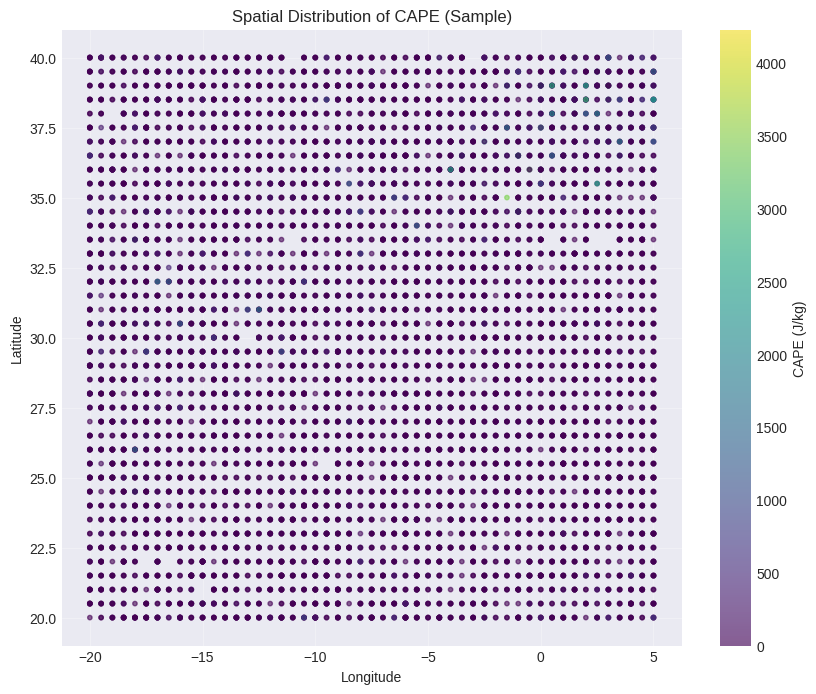

In [ ]:
# Step 2.4: Spatial analysis
print("\n" + "="*60)
print("SPATIAL ANALYSIS")
print("="*60)

print("\nSpatial coordinates summary:")
print(f"Latitude range: {df['lat'].min():.2f} to {df['lat'].max():.2f}")
print(f"Longitude range: {df['lon'].min():.2f} to {df['lon'].max():.2f}")
print(f"Unique latitude points: {df['lat'].nunique()}")
print(f"Unique longitude points: {df['lon'].nunique()}")

# Create a spatial grid visualization (sample)
plt.figure(figsize=(10, 8))
spatial_sample = df.sample(n=10000, random_state=42)
plt.scatter(spatial_sample['lon'], spatial_sample['lat'],
            c=spatial_sample['cape'], cmap='viridis', alpha=0.6, s=10)
plt.colorbar(label='CAPE (J/kg)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of CAPE (Sample)')
plt.grid(True, alpha=0.3)
plt.show()


VARIABLE DISTRIBUTION ANALYSIS

Analyzing distributions for 13 variables...


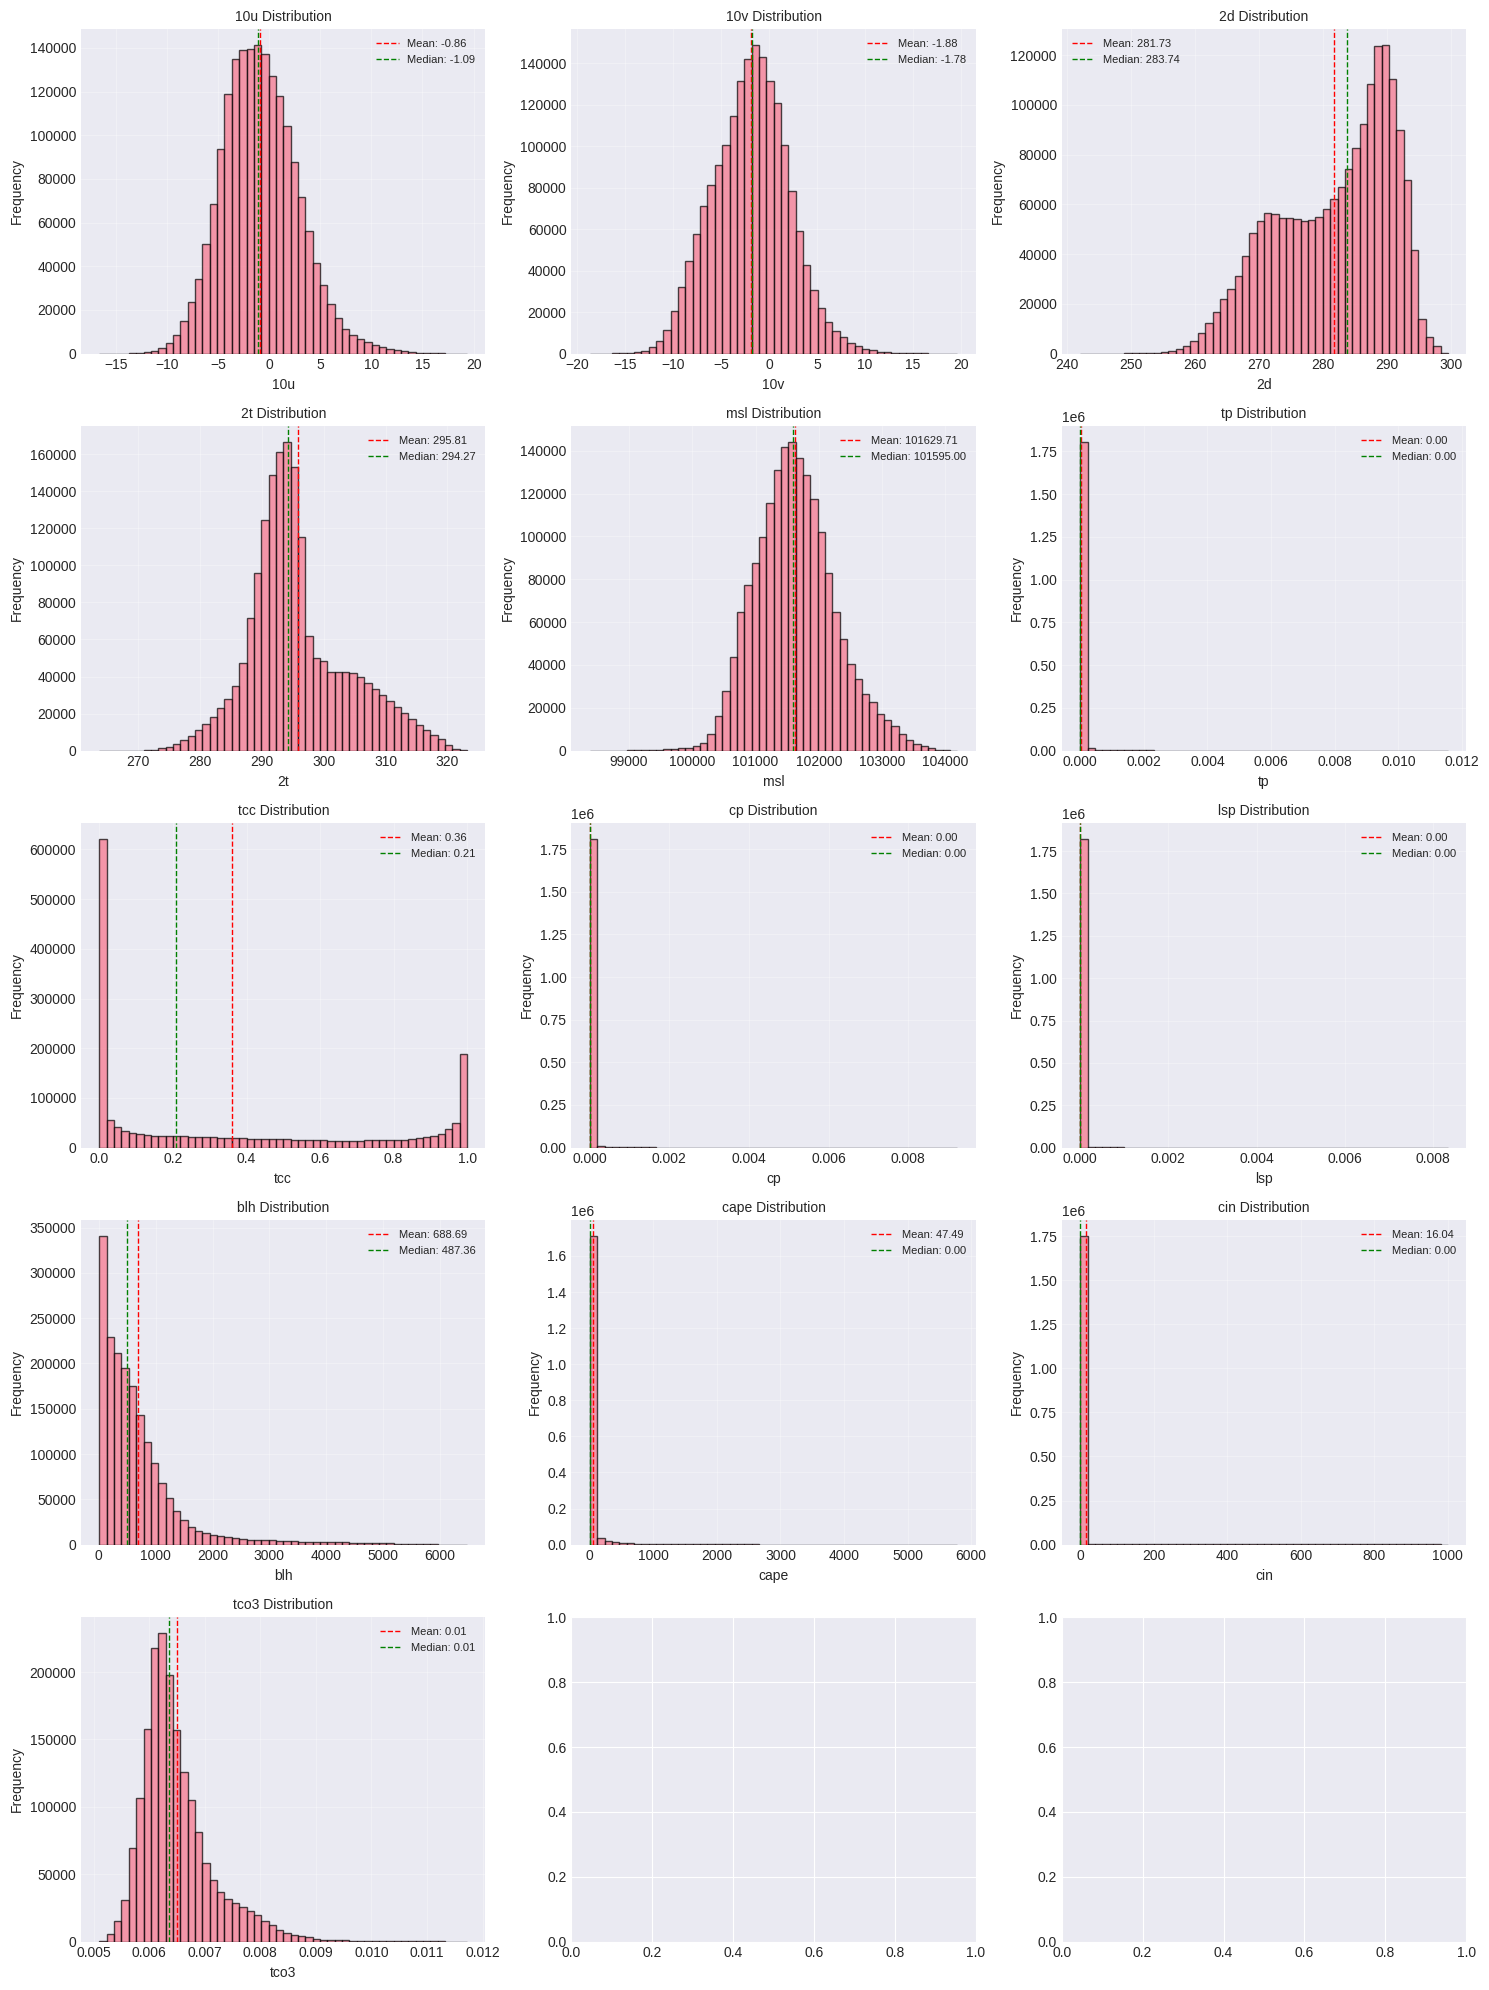

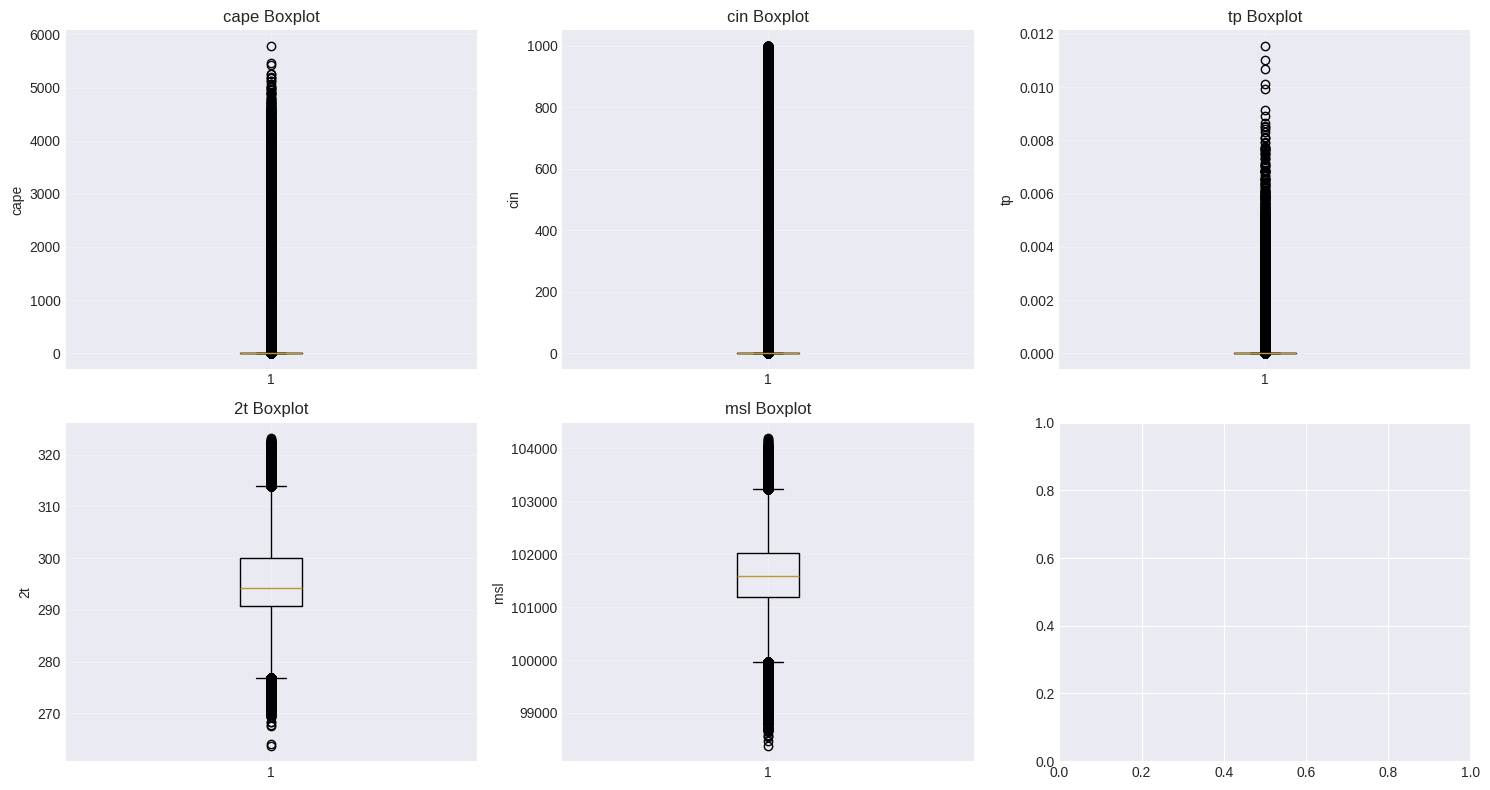

In [ ]:
# Step 2.5: Variable distribution analysis
print("\n" + "="*60)
print("VARIABLE DISTRIBUTION ANALYSIS")
print("="*60)

# Select meteorological variables
meteo_vars = ['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp',
              'lsp', 'blh', 'cape', 'cin', 'tco3']

print(f"\nAnalyzing distributions for {len(meteo_vars)} variables...")

# Create distribution plots
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for i, var in enumerate(meteo_vars):
    if i < len(axes):
        # Plot histogram
        ax = axes[i]
        ax.hist(df[var].dropna(), bins=50, edgecolor='black', alpha=0.7)
        ax.set_title(f'{var} Distribution', fontsize=10)
        ax.set_xlabel(var)
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

        # Add statistics
        mean_val = df[var].mean()
        median_val = df[var].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Create boxplots for key variables
key_vars = ['cape', 'cin', 'tp', '2t', 'msl']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(key_vars):
    if i < len(axes):
        ax = axes[i]
        ax.boxplot(df[var].dropna(), vert=True)
        ax.set_title(f'{var} Boxplot', fontsize=12)
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TARGET VARIABLE ANALYSIS: CAPE

CAPE Statistics:
Mean: 47.49 J/kg
Std: 233.44 J/kg
Min: 0.00 J/kg
25%: 0.00 J/kg
50% (Median): 0.00 J/kg
75%: 2.38 J/kg
Max: 5786.50 J/kg
Skewness: 8.452
Kurtosis: 90.076


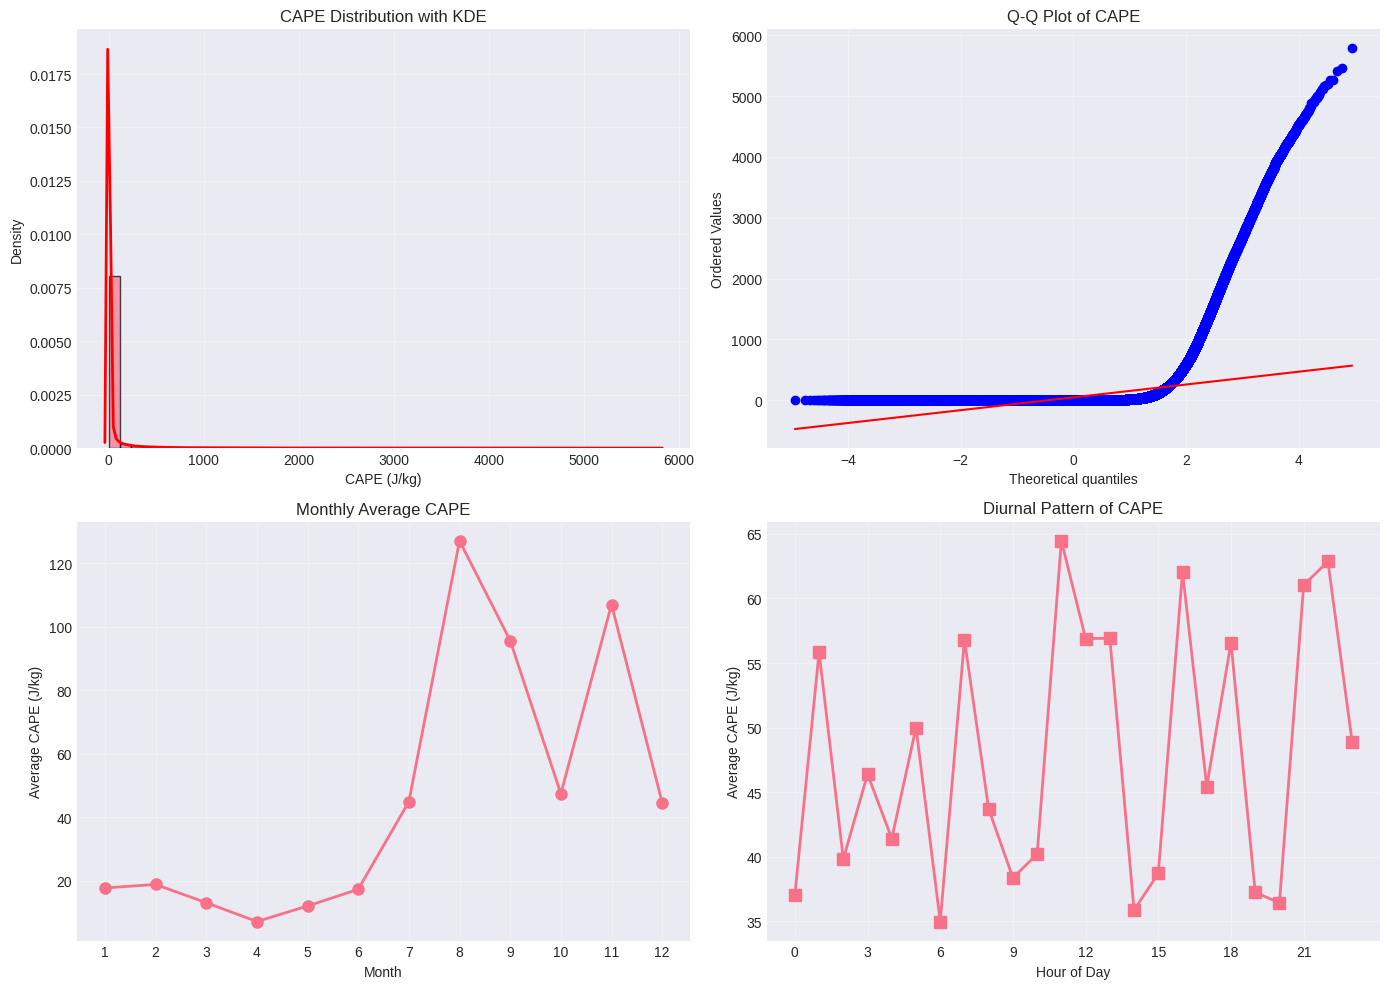

In [ ]:
# Step 2.6: Target variable (CAPE) analysis
print("\n" + "="*60)
print("TARGET VARIABLE ANALYSIS: CAPE")
print("="*60)

cape_data = df['cape']

print(f"\nCAPE Statistics:")
print(f"Mean: {cape_data.mean():.2f} J/kg")
print(f"Std: {cape_data.std():.2f} J/kg")
print(f"Min: {cape_data.min():.2f} J/kg")
print(f"25%: {cape_data.quantile(0.25):.2f} J/kg")
print(f"50% (Median): {cape_data.median():.2f} J/kg")
print(f"75%: {cape_data.quantile(0.75):.2f} J/kg")
print(f"Max: {cape_data.max():.2f} J/kg")
print(f"Skewness: {cape_data.skew():.3f}")
print(f"Kurtosis: {cape_data.kurtosis():.3f}")

# Create detailed CAPE analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram with KDE
axes[0, 0].hist(cape_data, bins=50, edgecolor='black', alpha=0.7, density=True)
sns.kdeplot(cape_data, ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].set_title('CAPE Distribution with KDE', fontsize=12)
axes[0, 0].set_xlabel('CAPE (J/kg)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(cape_data, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of CAPE', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# CAPE vs Time (monthly average)
monthly_cape = df.groupby('month')['cape'].mean()
axes[1, 0].plot(monthly_cape.index, monthly_cape.values, 'o-', linewidth=2, markersize=8)
axes[1, 0].set_title('Monthly Average CAPE', fontsize=12)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average CAPE (J/kg)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# CAPE vs Hour (diurnal pattern)
hourly_cape = df.groupby('hour')['cape'].mean()
axes[1, 1].plot(hourly_cape.index, hourly_cape.values, 's-', linewidth=2, markersize=8)
axes[1, 1].set_title('Diurnal Pattern of CAPE', fontsize=12)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average CAPE (J/kg)')
axes[1, 1].set_xticks(range(0, 24, 3))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS - 13 SPECIFIED VARIABLES

Analyzing correlations for the 13 specified variables:
   1. 10u
   2. 10v
   3. 2d
   4. 2t
   5. msl
   6. tp
   7. tcc
   8. cp
   9. lsp
  10. blh
  11. cape
  12. cin
  13. tco3

Correlation matrix shape: (13, 13)

Correlations with CAPE (target variable):
------------------------------------------------------------
Variable   | Correlation 
------------------------------------------------------------
cin        |       0.4647
2d         |       0.2401
10v        |       0.0899
cp         |       0.0792
tp         |       0.0673
tco3       |       0.0447
tcc        |       0.0340
2t         |       0.0254
lsp        |       0.0203
10u        |      -0.0111
msl        |      -0.0437
blh        |      -0.0567

Creating correlation matrix heatmap for 13 variables...


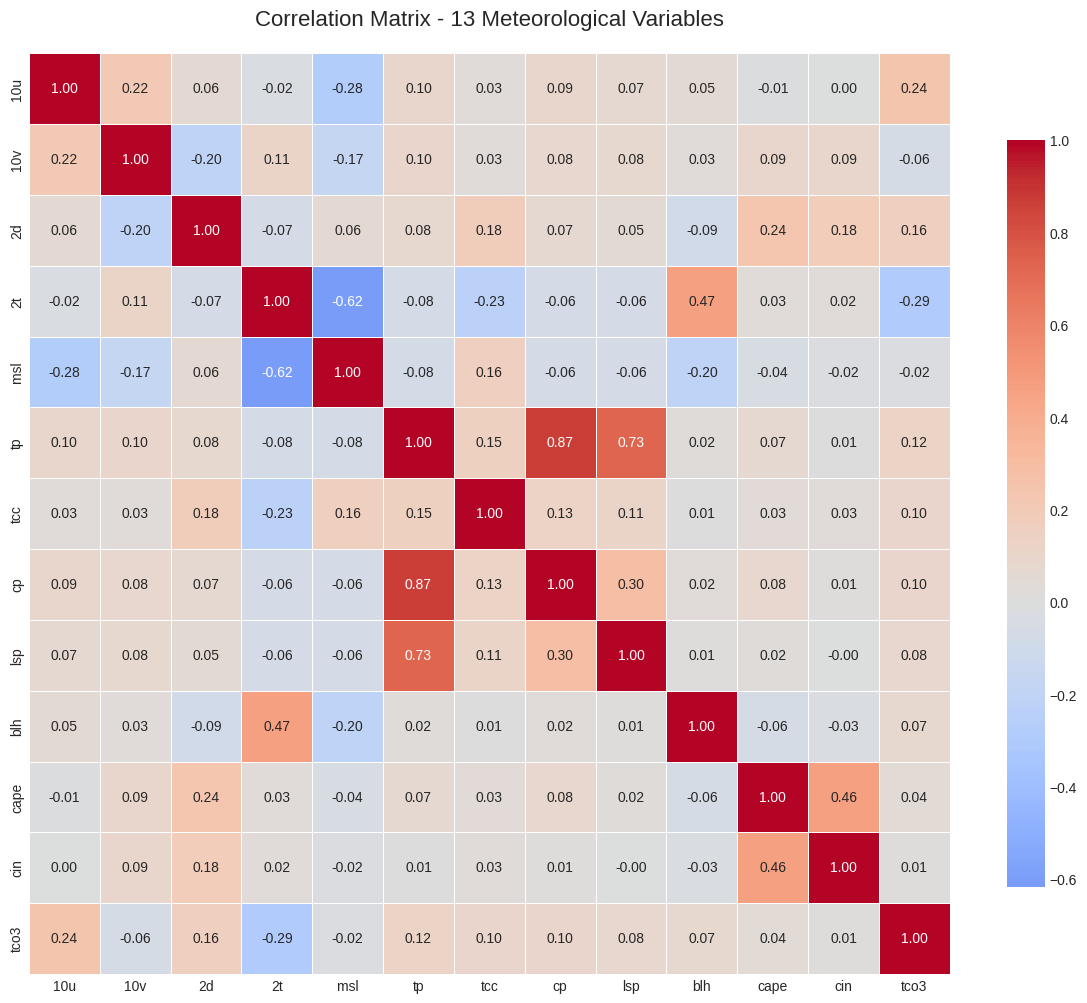


KEY CORRELATION INSIGHTS

Top 3 positive correlations with CAPE:
  cin       : 0.4647
  2d        : 0.2401
  10v       : 0.0899

Top 3 negative correlations with CAPE:
  10u       : -0.0111
  msl       : -0.0437
  blh       : -0.0567

Strongest overall correlations (absolute value > 0.7):
  tp         - cp        : 0.871 (positive)
  tp         - lsp       : 0.729 (positive)

PAIRPLOT VISUALIZATION

Creating pairplot for: ['cape', '2t', 'tp', 'tcc', 'blh']


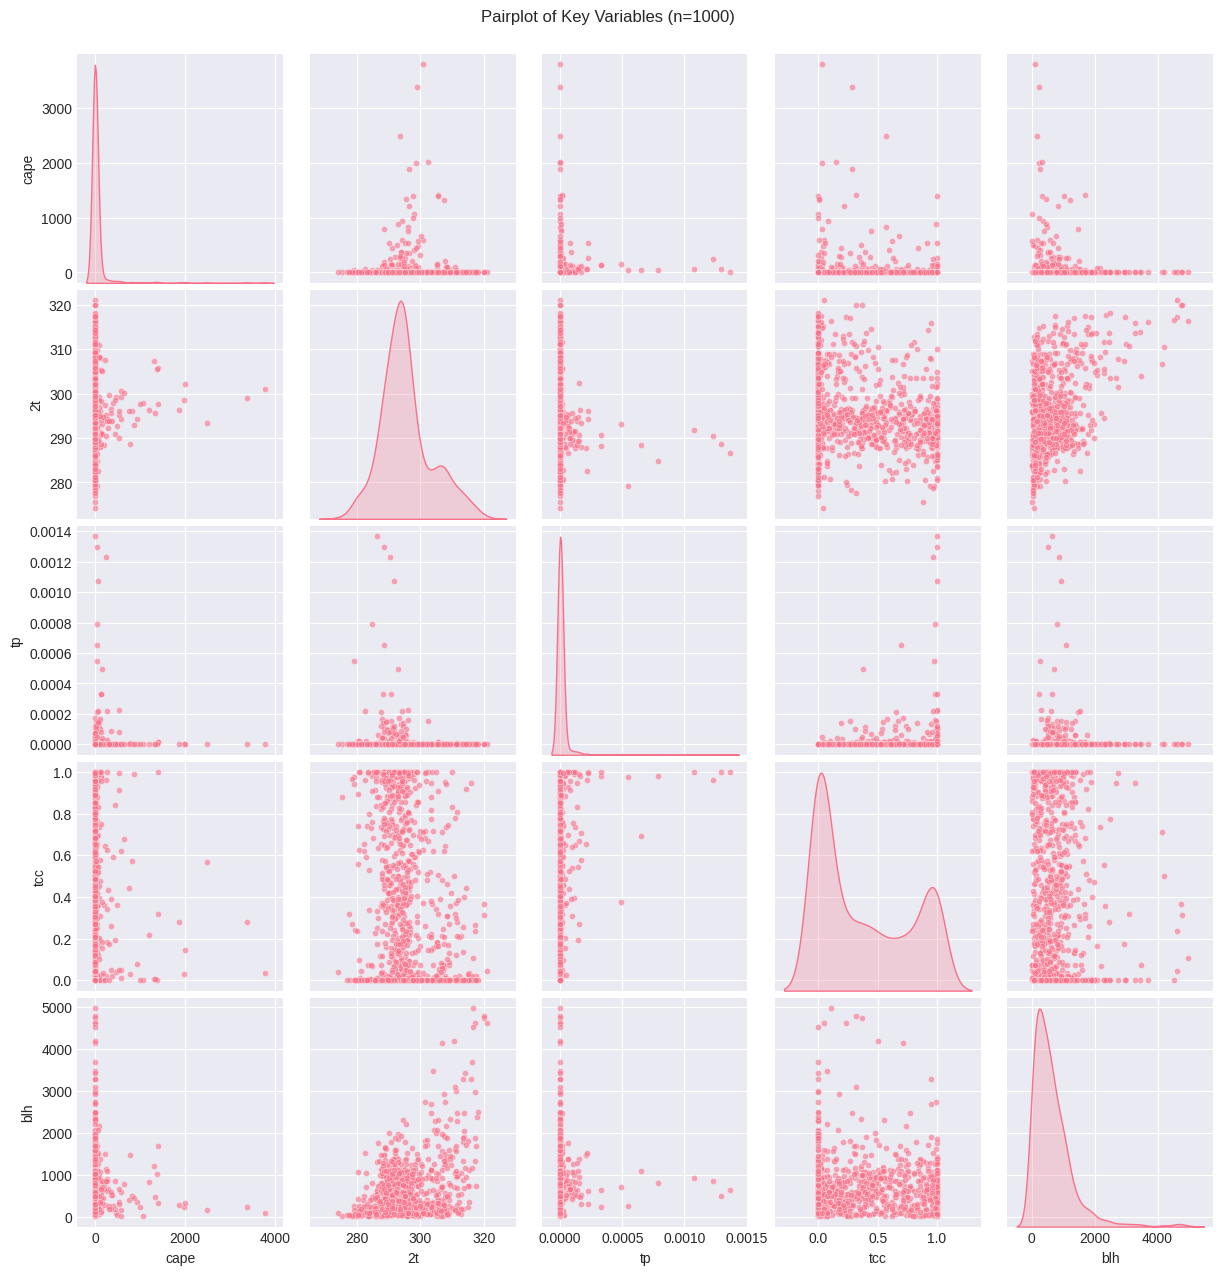


SAVING CORRELATION MATRIX
13-variable correlation matrix saved to: /content/drive/MyDrive/meteo_2024_correlation_13vars.csv
CAPE correlations saved to: /content/drive/MyDrive/meteo_2024_cape_correlations.csv

CORRELATION ANALYSIS COMPLETE

Analysis Summary:

1. Variables analyzed: 13 out of 13 specified
2. Correlation matrix: 13 × 13
3. Target variable: 'cape'
4. Strongest correlations identified
5. Files saved:
   • /content/drive/MyDrive/meteo_2024_correlation_13vars.csv - Full correlation matrix
   • /content/drive/MyDrive/meteo_2024_cape_correlations.csv - CAPE correlations

Key insights from correlation analysis will inform feature selection
for the CNN model predicting CAPE.



In [ ]:
# Step 2.7: Correlation analysis - ONLY the 13 specified variables
print("\n" + "="*60)
print("CORRELATION ANALYSIS - 13 SPECIFIED VARIABLES")
print("="*60)

# Define the 13 specified variables
specified_vars = ['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp',
                  'lsp', 'blh', 'cape', 'cin', 'tco3']

print(f"\nAnalyzing correlations for the 13 specified variables:")
for i, var in enumerate(specified_vars, 1):
    print(f"  {i:2d}. {var}")

# Check which variables exist in the dataset
available_vars = [var for var in specified_vars if var in df.columns]
missing_vars = [var for var in specified_vars if var not in df.columns]

if missing_vars:
    print(f"\nWarning: Some variables not found in dataset: {missing_vars}")
    print(f"Available variables: {available_vars}")

# Calculate correlation matrix for available variables
corr_matrix_13 = df[available_vars].corr()

print(f"\nCorrelation matrix shape: {corr_matrix_13.shape}")

# Top correlations with CAPE (target variable)
if 'cape' in corr_matrix_13.columns:
    cape_correlations = corr_matrix_13['cape'].sort_values(ascending=False)
    print("\nCorrelations with CAPE (target variable):")
    print("-" * 60)
    print(f"{'Variable':10s} | {'Correlation':12s}")
    print("-" * 60)
    for var, corr in cape_correlations.items():
        if var != 'cape':
            print(f"{var:10s} | {corr:12.4f}")

# Visualize FULL correlation matrix for the 13 variables
print("\nCreating correlation matrix heatmap for 13 variables...")
plt.figure(figsize=(12, 10))

# Create the heatmap WITHOUT triangular mask - FULL matrix
sns.heatmap(corr_matrix_13, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix - 13 Meteorological Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Highlight key correlations
print("\n" + "="*60)
print("KEY CORRELATION INSIGHTS")
print("="*60)

# Strongest positive correlations with CAPE
if 'cape' in cape_correlations:
    cape_corr_no_self = cape_correlations.drop('cape')
    top_pos = cape_corr_no_self.head(3)
    top_neg = cape_corr_no_self.tail(3)

    print("\nTop 3 positive correlations with CAPE:")
    for var, corr in top_pos.items():
        print(f"  {var:10s}: {corr:.4f}")

    print("\nTop 3 negative correlations with CAPE:")
    for var, corr in top_neg.items():
        print(f"  {var:10s}: {corr:.4f}")

# Strongest overall correlations (excluding self-correlations)
print("\nStrongest overall correlations (absolute value > 0.7):")
strong_corrs = []
for i in range(len(corr_matrix_13.columns)):
    for j in range(i+1, len(corr_matrix_13.columns)):
        corr_val = corr_matrix_13.iloc[i, j]
        if abs(corr_val) > 0.7:
            var1 = corr_matrix_13.columns[i]
            var2 = corr_matrix_13.columns[j]
            strong_corrs.append((var1, var2, corr_val))

if strong_corrs:
    strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    for var1, var2, corr_val in strong_corrs[:10]:  # Show top 10
        direction = "positive" if corr_val > 0 else "negative"
        print(f"  {var1:10s} - {var2:10s}: {corr_val:.3f} ({direction})")
else:
    print("  No very strong correlations found")

# Create a pairplot for the most interesting variables
print("\n" + "="*60)
print("PAIRPLOT VISUALIZATION")
print("="*60)

# Select 5-6 key variables for pairplot (including cape)
key_vars_for_pairplot = ['cape', '2t', 'tp', 'tcc', 'blh']
key_vars_for_pairplot = [v for v in key_vars_for_pairplot if v in available_vars]

if len(key_vars_for_pairplot) >= 3:
    print(f"\nCreating pairplot for: {key_vars_for_pairplot}")

    # Take a sample for pairplot (too many points will be slow)
    sample_size = min(1000, len(df))
    pairplot_sample = df[key_vars_for_pairplot].sample(n=sample_size, random_state=42)

    # Create pairplot
    pairplot = sns.pairplot(pairplot_sample, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
    pairplot.fig.suptitle(f'Pairplot of Key Variables (n={sample_size})', y=1.02)
    plt.show()
else:
    print("Not enough key variables available for pairplot")

# Save the 13-variable correlation matrix
print("\n" + "="*60)
print("SAVING CORRELATION MATRIX")
print("="*60)

correlation_path_13 = '/content/drive/MyDrive/meteo_2024_correlation_13vars.csv'
corr_matrix_13.to_csv(correlation_path_13)
print(f"13-variable correlation matrix saved to: {correlation_path_13}")

# Also save correlation values with CAPE
if 'cape' in cape_correlations:
    cape_corr_df = pd.DataFrame({
        'variable': cape_correlations.index,
        'correlation_with_cape': cape_correlations.values
    })
    cape_corr_path = '/content/drive/MyDrive/meteo_2024_cape_correlations.csv'
    cape_corr_df.to_csv(cape_corr_path, index=False)
    print(f"CAPE correlations saved to: {cape_corr_path}")

print("\n" + "="*60)
print("CORRELATION ANALYSIS COMPLETE")
print("="*60)
print(f"""
Analysis Summary:

1. Variables analyzed: {len(available_vars)} out of 13 specified
2. Correlation matrix: {corr_matrix_13.shape[0]} × {corr_matrix_13.shape[1]}
3. Target variable: 'cape'
4. Strongest correlations identified
5. Files saved:
   • {correlation_path_13} - Full correlation matrix
   • {cape_corr_path if 'cape' in cape_correlations else 'N/A'} - CAPE correlations

Key insights from correlation analysis will inform feature selection
for the CNN model predicting CAPE.
""")


PRECIPITATION ANALYSIS - CORRECTED

Precipitation Statistics:

tp:
  Non-zero values: 370,730 (20.19%)
  Max value: 0.011557 m
  Mean (non-zero): 0.000096 m
  Sum total: 35.720459 m

cp:
  Non-zero values: 296,181 (16.13%)
  Max value: 0.009238 m
  Mean (non-zero): 0.000080 m
  Sum total: 23.754315 m

lsp:
  Non-zero values: 260,054 (14.16%)
  Max value: 0.008339 m
  Mean (non-zero): 0.000046 m
  Sum total: 11.967532 m

Maximum precipitation: 11.56 mm
Days with any precipitation: 335 out of 335 days (100.0%)


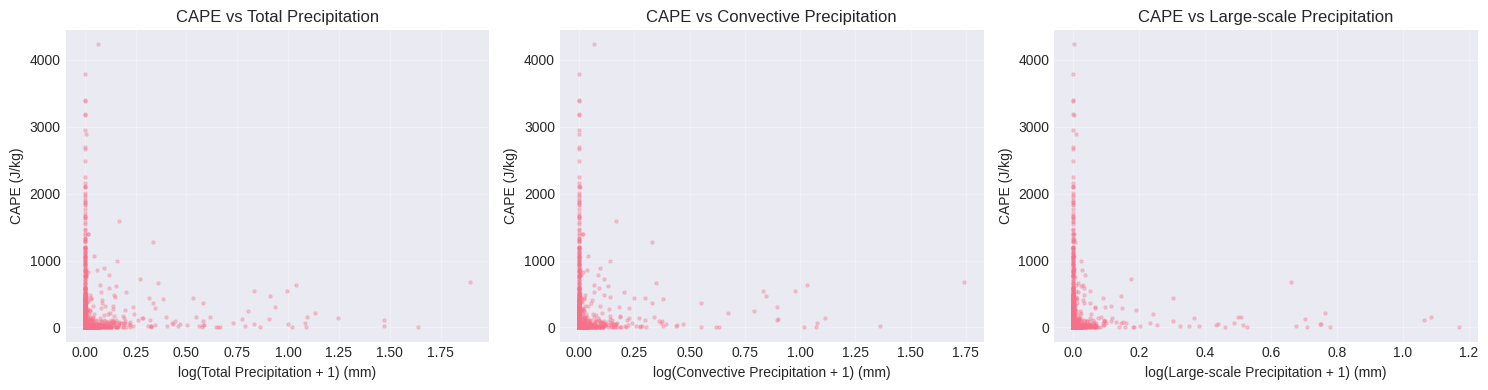

In [ ]:
# Fixed Step 2.8: Precipitation analysis (corrected)
print("\n" + "="*60)
print("PRECIPITATION ANALYSIS - CORRECTED")
print("="*60)

precip_vars = ['tp', 'cp', 'lsp']

print("\nPrecipitation Statistics:")
for var in precip_vars:
    data = df[var]
    print(f"\n{var}:")
    print(f"  Non-zero values: {(data > 0).sum():,} ({((data > 0).sum()/len(data)*100):.2f}%)")
    print(f"  Max value: {data.max():.6f} m")
    print(f"  Mean (non-zero): {data[data > 0].mean():.6f} m")
    print(f"  Sum total: {data.sum():.6f} m")

# Convert precipitation from meters to mm for better interpretation
df['tp_mm'] = df['tp'] * 1000
df['cp_mm'] = df['cp'] * 1000
df['lsp_mm'] = df['lsp'] * 1000

print(f"\nMaximum precipitation: {df['tp_mm'].max():.2f} mm")

# Fix: Count days with any precipitation
# Group by date and check if any precipitation occurred on that day
df['date'] = df['time'].dt.date
days_with_precip = df.groupby('date')['tp_mm'].apply(lambda x: (x > 0).any()).sum()
total_days = df['date'].nunique()
print(f"Days with any precipitation: {days_with_precip} out of {total_days} days ({days_with_precip/total_days*100:.1f}%)")

# Precipitation vs CAPE relationship
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

precip_mm_vars = ['tp_mm', 'cp_mm', 'lsp_mm']
titles = ['Total Precipitation', 'Convective Precipitation', 'Large-scale Precipitation']

for i, (var, title) in enumerate(zip(precip_mm_vars, titles)):
    # Sample for better visualization
    sample_data = df.sample(n=5000, random_state=42) if len(df) > 5000 else df

    # Log scale for better visualization (add small constant to avoid log(0))
    axes[i].scatter(np.log1p(sample_data[var]), sample_data['cape'], alpha=0.3, s=5)
    axes[i].set_xlabel(f'log({title} + 1) (mm)')
    axes[i].set_ylabel('CAPE (J/kg)')
    axes[i].set_title(f'CAPE vs {title}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Remove temporary date column if we don't need it
if 'date' in df.columns and 'date' not in ['date', 'year', 'month', 'day', 'hour']:
    df.drop('date', axis=1, inplace=True)

In [ ]:
# Step 3: Feature Importance Analysis - USING ONLY ORIGINAL 13 VARIABLES (CLEAN VERSION)
print("="*60)
print("STEP 3: FEATURE IMPORTANCE ANALYSIS - CLEAN VERSION")
print("="*60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
print("\nLoading cleaned dataset...")
cleaned_path = '/content/drive/MyDrive/meteo_2024_sampled_clean.csv.gz'
df = pd.read_csv(cleaned_path, compression='gzip')

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

print(f"Dataset shape: {df.shape}")
print(f"Records: {df.shape[0]:,}")

# The 13 original variables
original_vars = ['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp',
                 'lsp', 'blh', 'cape', 'cin', 'tco3']

print(f"\nOriginal 13 variables:")
for i, var in enumerate(original_vars, 1):
    print(f"  {i:2d}. {var}")

# Check which ones exist in our dataset
available_vars = [var for var in original_vars if var in df.columns]
print(f"\nAvailable in dataset: {len(available_vars)} variables")

STEP 3: FEATURE IMPORTANCE ANALYSIS - CLEAN VERSION

Loading cleaned dataset...
Dataset shape: (1835898, 16)
Records: 1,835,898

Original 13 variables:
   1. 10u
   2. 10v
   3. 2d
   4. 2t
   5. msl
   6. tp
   7. tcc
   8. cp
   9. lsp
  10. blh
  11. cape
  12. cin
  13. tco3

Available in dataset: 13 variables


In [ ]:
# Step 3.1: Unit Conversions (REPLACE original variables with converted ones)
print("\n" + "="*60)
print("UNIT CONVERSIONS - REPLACE ORIGINALS")
print("="*60)

# Create a copy for processing
df_processed = df.copy()

# Store original units for reference
original_units = {
    '2t': 'K (Kelvin)',
    '2d': 'K (Kelvin)',
    'msl': 'Pa (Pascal)',
    'tp': 'm (meters)',
    'cp': 'm (meters)',
    'lsp': 'm (meters)'
}

print("\nConverting variables to more interpretable units (REPLACING originals):")

# 1. Convert temperatures from Kelvin to Celsius (REPLACE)
if '2t' in df_processed.columns:
    df_processed['2t'] = df_processed['2t'] - 273.15  # Replace with Celsius
    print(f"  • 2t: {original_units.get('2t')} → °C (Celsius)")

if '2d' in df_processed.columns:
    df_processed['2d'] = df_processed['2d'] - 273.15  # Replace with Celsius
    print(f"  • 2d: {original_units.get('2d')} → °C (Celsius)")

# 2. Convert pressure from Pa to hPa (REPLACE)
if 'msl' in df_processed.columns:
    df_processed['msl'] = df_processed['msl'] / 100  # Replace with hPa
    print(f"  • msl: {original_units.get('msl')} → hPa (hectoPascal)")

# 3. Convert precipitation from m to mm (REPLACE)
precip_vars = ['tp', 'cp', 'lsp']
for var in precip_vars:
    if var in df_processed.columns:
        df_processed[var] = df_processed[var] * 1000  # Replace with mm
        print(f"  • {var}: {original_units.get(var)} → mm (millimeters)")

print(f"\nDataset still has {len(df_processed.columns)} columns")
print("All variables now in interpretable units")


UNIT CONVERSIONS - REPLACE ORIGINALS

Converting variables to more interpretable units (REPLACING originals):
  • 2t: K (Kelvin) → °C (Celsius)
  • 2d: K (Kelvin) → °C (Celsius)
  • msl: Pa (Pascal) → hPa (hectoPascal)
  • tp: m (meters) → mm (millimeters)
  • cp: m (meters) → mm (millimeters)
  • lsp: m (meters) → mm (millimeters)

Dataset still has 16 columns
All variables now in interpretable units


In [ ]:
# Step 3.2: Check the converted data
print("\n" + "="*60)
print("CHECKING CONVERTED DATA")
print("="*60)

print("\nSample values after conversion:")
sample_cols = ['2t', '2d', 'msl', 'tp', 'cp', 'lsp']
for col in sample_cols:
    if col in df_processed.columns:
        print(f"{col:6s}: Min={df_processed[col].min():8.2f}, Max={df_processed[col].max():8.2f}, Mean={df_processed[col].mean():8.2f}")

print("\nUnits after conversion:")
converted_units = {
    '10u': 'm/s',
    '10v': 'm/s',
    '2t': '°C',
    '2d': '°C',
    'msl': 'hPa',
    'tp': 'mm',
    'tcc': '0-1',
    'cp': 'mm',
    'lsp': 'mm',
    'blh': 'm',
    'cape': 'J/kg',
    'cin': 'J/kg',
    'tco3': 'kg/m²'
}

for var in original_vars:
    if var in df_processed.columns:
        print(f"  {var:6s}: {converted_units.get(var, 'unknown')}")


CHECKING CONVERTED DATA

Sample values after conversion:
2t    : Min=   -9.44, Max=   50.03, Mean=   22.66
2d    : Min=  -31.15, Max=   26.30, Mean=    8.58
msl   : Min=  983.80, Max= 1041.92, Mean= 1016.30
tp    : Min=    0.00, Max=   11.56, Mean=    0.02
cp    : Min=    0.00, Max=    9.24, Mean=    0.01
lsp   : Min=    0.00, Max=    8.34, Mean=    0.01

Units after conversion:
  10u   : m/s
  10v   : m/s
  2d    : °C
  2t    : °C
  msl   : hPa
  tp    : mm
  tcc   : 0-1
  cp    : mm
  lsp   : mm
  blh   : m
  cape  : J/kg
  cin   : J/kg
  tco3  : kg/m²


In [ ]:
# Step 3.3: Feature Importance Analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS WITH RANDOM FOREST")
print("="*60)

# Target variable
target = 'cape'

if target in df_processed.columns:
    print(f"\nTarget variable: {target} ({converted_units.get(target, 'unknown')})")

    # Prepare features (use ALL original variables except target)
    feature_candidates = [var for var in original_vars
                         if var != target
                         and var in df_processed.columns
                         and pd.api.types.is_numeric_dtype(df_processed[var])]

    print(f"\nFeature candidates: {len(feature_candidates)}")
    print("Features to analyze:")
    for i, feat in enumerate(feature_candidates, 1):
        print(f"  {i:2d}. {feat:6s} ({converted_units.get(feat, 'unknown')})")

    # Calculate correlations with target
    print("\n" + "="*50)
    print("CORRELATION WITH TARGET (CAPE)")
    print("="*50)

    correlations = {}
    for feat in feature_candidates:
        corr = df_processed[feat].corr(df_processed[target])
        correlations[feat] = corr

    # Sort by absolute correlation
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    print(f"\n{'Feature':6s} | {'Units':8s} | {'Correlation':12s} | {'Abs Corr':10s}")
    print("-" * 50)
    for feat, corr in sorted_correlations:
        print(f"{feat:6s} | {converted_units.get(feat, ''):8s} | {corr:12.4f} | {abs(corr):10.4f}")

    # Prepare data for Random Forest
    X = df_processed[feature_candidates]
    y = df_processed[target]

    print(f"\nData shapes: X={X.shape}, y={y.shape}")

    # Sample data for faster computation (if needed)
    sample_size = min(200000, len(X))
    if len(X) > sample_size:
        print(f"Sampling {sample_size:,} records for faster computation...")
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, random_state=42, shuffle=True)
    else:
        X_sample, y_sample = X, y

    print(f"Using {len(X_sample):,} samples for Random Forest")

    # Train Random Forest
    print("\nTraining Random Forest (n_estimators=100)...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=0)
    rf.fit(X_sample, y_sample)

    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_candidates,
        'importance': importances,
        'correlation': [correlations[feat] for feat in feature_candidates],
        'units': [converted_units.get(feat, '') for feat in feature_candidates]
    }).sort_values('importance', ascending=False)

    print("\n" + "="*60)
    print("FEATURE IMPORTANCE RANKING")
    print("="*60)
    print(f"\n{'Rank':4s} | {'Feature':6s} | {'Units':8s} | {'RF Importance':15s} | {'Correlation':12s}")
    print("-" * 60)
    for i, (_, row) in enumerate(feature_importance_df.iterrows(), 1):
        print(f"{i:4d} | {row['feature']:6s} | {row['units']:8s} | {row['importance']:15.4f} | {row['correlation']:12.4f}")
        if i >= 12:  # Show all 12 features (excluding cape)
            break


FEATURE IMPORTANCE ANALYSIS WITH RANDOM FOREST

Target variable: cape (J/kg)

Feature candidates: 12
Features to analyze:
   1. 10u    (m/s)
   2. 10v    (m/s)
   3. 2d     (°C)
   4. 2t     (°C)
   5. msl    (hPa)
   6. tp     (mm)
   7. tcc    (0-1)
   8. cp     (mm)
   9. lsp    (mm)
  10. blh    (m)
  11. cin    (J/kg)
  12. tco3   (kg/m²)

CORRELATION WITH TARGET (CAPE)

Feature | Units    | Correlation  | Abs Corr  
--------------------------------------------------
cin    | J/kg     |       0.4647 |     0.4647
2d     | °C       |       0.2401 |     0.2401
10v    | m/s      |       0.0899 |     0.0899
cp     | mm       |       0.0792 |     0.0792
tp     | mm       |       0.0673 |     0.0673
blh    | m        |      -0.0567 |     0.0567
tco3   | kg/m²    |       0.0447 |     0.0447
msl    | hPa      |      -0.0437 |     0.0437
tcc    | 0-1      |       0.0340 |     0.0340
2t     | °C       |       0.0254 |     0.0254
lsp    | mm       |       0.0203 |     0.0203
10u    | m/s    


VISUALIZING FEATURE IMPORTANCES


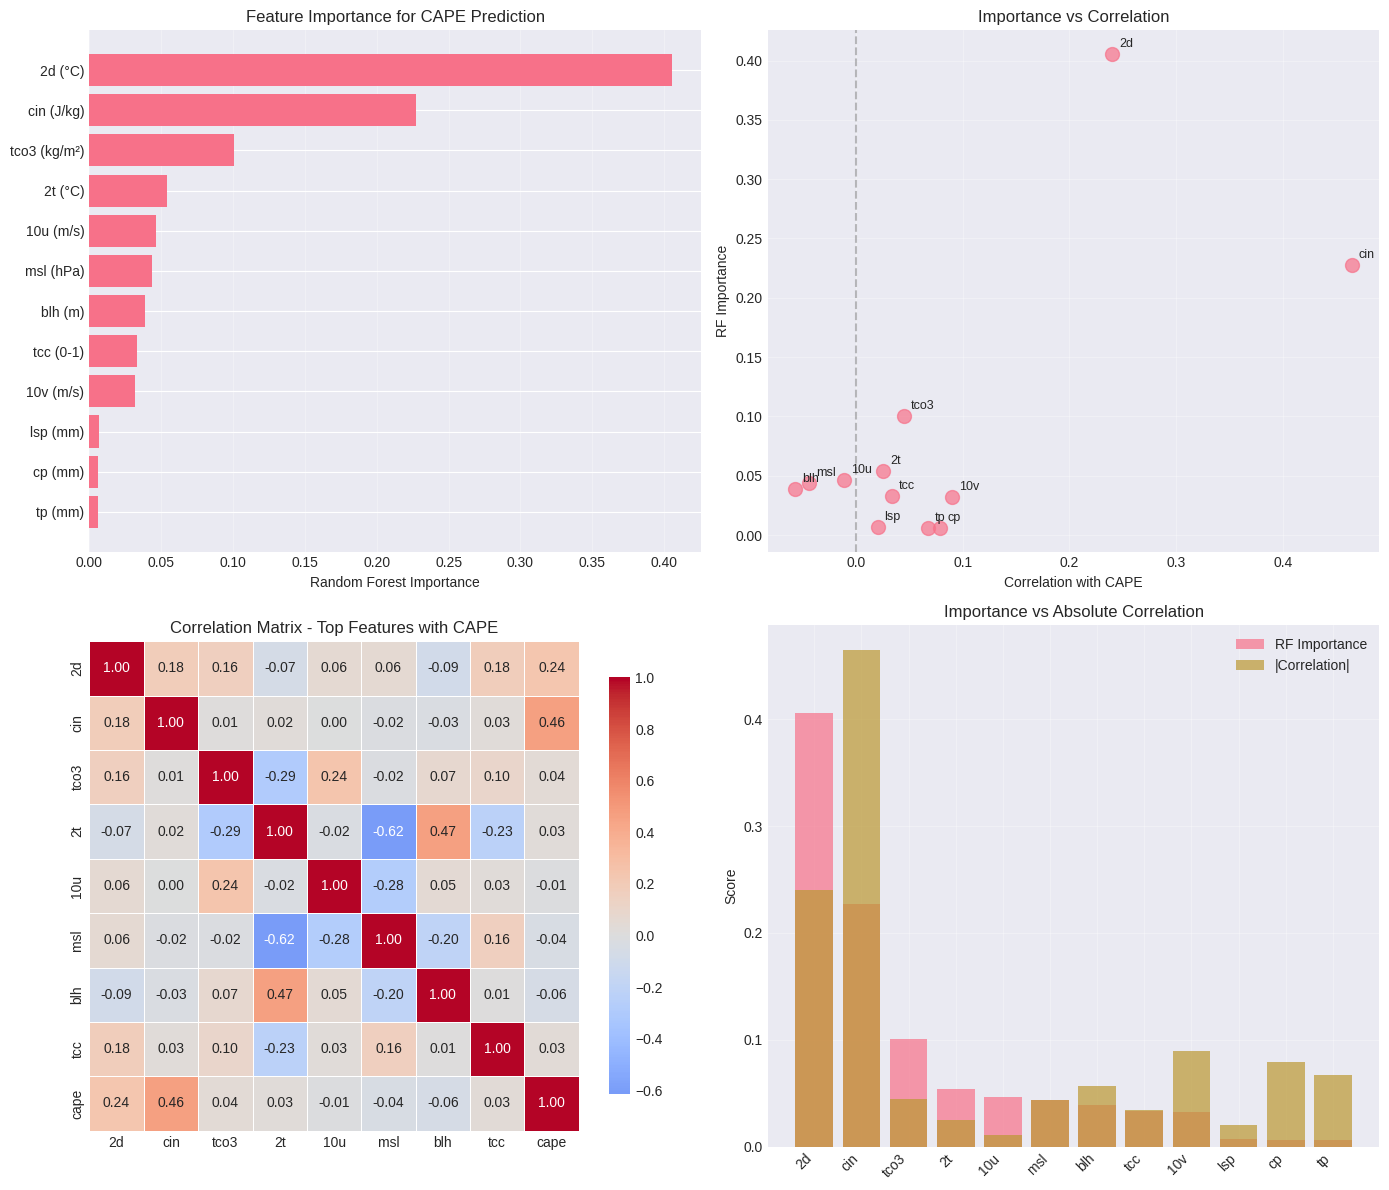

In [ ]:
# Step 3.4: Visualize Results
print("\n" + "="*60)
print("VISUALIZING FEATURE IMPORTANCES")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Bar plot of feature importances
top_n = len(feature_importance_df)
features = feature_importance_df['feature'].values
importances = feature_importance_df['importance'].values

axes[0, 0].barh(range(top_n), importances)
axes[0, 0].set_yticks(range(top_n))
axes[0, 0].set_yticklabels([f"{f} ({converted_units.get(f, '')})" for f in features])
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Random Forest Importance')
axes[0, 0].set_title('Feature Importance for CAPE Prediction', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Correlation vs Importance scatter
correlations = feature_importance_df['correlation'].values
scatter = axes[0, 1].scatter(correlations, importances, s=100, alpha=0.7)
for i, (feat, corr, imp) in enumerate(zip(features, correlations, importances)):
    axes[0, 1].annotate(feat, (corr, imp), xytext=(5, 5),
                       textcoords='offset points', fontsize=9)
axes[0, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Correlation with CAPE')
axes[0, 1].set_ylabel('RF Importance')
axes[0, 1].set_title('Importance vs Correlation', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Correlation heatmap (top features)
top_features = feature_importance_df.head(8)['feature'].tolist()
if target not in top_features:
    top_features.append(target)

corr_subset = df_processed[top_features].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix - Top Features with CAPE', fontsize=12)

# 4. Importance comparison chart
axes[1, 1].bar(range(top_n), importances, alpha=0.7, label='RF Importance')
axes[1, 1].bar(range(top_n), np.abs(correlations), alpha=0.7, label='|Correlation|')
axes[1, 1].set_xticks(range(top_n))
axes[1, 1].set_xticklabels(features, rotation=45, ha='right')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Importance vs Absolute Correlation', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Step 3.5: Feature Selection and Save Final Dataset
print("\n" + "="*60)
print("FEATURE SELECTION AND FINAL DATASET PREPARATION")
print("="*60)

print("\nSelecting features for CNN model...")

# We'll use ALL 12 predictor variables (all except cape)
selected_features = [feat for feat in original_vars if feat != target and feat in df_processed.columns]

print(f"\nSelected {len(selected_features)} features for CNN model:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feat:6s} ({converted_units.get(feat, 'unknown')})")

# Create final dataset with time, all features, and target
final_features = selected_features + [target, 'time']
df_final = df_processed[final_features].copy()

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features: {len(selected_features)} predictors + 1 target ({target}) + time")
print(f"Records: {len(df_final):,}")

# Save final dataset
final_path = '/content/drive/MyDrive/meteo_2024_cnn_ready_final.csv.gz'
df_final.to_csv(final_path, index=False, compression='gzip')

import os
file_size = os.path.getsize(final_path) / (1024**2)
print(f"\nFinal CNN-ready dataset saved to: {final_path}")
print(f"File size: {file_size:.2f} MB")

# Save feature importance results
importance_path = '/content/drive/MyDrive/meteo_2024_feature_importance_final.csv'
feature_importance_df.to_csv(importance_path, index=False)
print(f"Feature importance saved to: {importance_path}")

# Create and save summary
summary_data = {
    'target_variable': target,
    'target_units': converted_units.get(target, 'unknown'),
    'predictor_features': len(selected_features),
    'total_records': len(df_final),
    'file_size_mb': f"{file_size:.2f}",
    'top_3_features_by_importance': ', '.join(feature_importance_df.head(3)['feature'].tolist()),
    'top_feature_importance': feature_importance_df.iloc[0]['importance'],
    'top_feature_correlation': feature_importance_df.iloc[0]['correlation'],
    'all_features': ', '.join(selected_features),
    'all_units': ', '.join([converted_units.get(f, '') for f in selected_features])
}

summary_df = pd.DataFrame(list(summary_data.items()), columns=['Parameter', 'Value'])
summary_path = '/content/drive/MyDrive/meteo_2024_step3_summary.csv'
summary_df.to_csv(summary_path, index=False)

print("\n" + "="*60)
print("STEP 3 COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"""
SUMMARY:

1. Unit Conversions Applied (REPLACED originals):
   • Temperature: K → °C
   • Pressure: Pa → hPa
   • Precipitation: m → mm

2. Feature Importance Analysis:
   • Analyzed all 12 predictor variables
   • Target variable: {target} ({converted_units.get(target, '')})
   • Random Forest identified most important features

3. Features Selected for CNN:
   • Using ALL {len(selected_features)} predictor variables
   • Each in interpretable units

4. Files Created:
   • {final_path} - Final CNN-ready dataset ({file_size:.2f} MB)
   • {importance_path} - Feature importance rankings
   • {summary_path} - Summary of Step 3

5. Dataset Ready for CNN:
   • Shape: {df_final.shape}
   • Features: {len(selected_features)} predictors
   • Target: {target} values
   • Temporal dimension: time column included

NEXT STEP: Train-Test Splitting for CNN Model
""")


FEATURE SELECTION AND FINAL DATASET PREPARATION

Selecting features for CNN model...

Selected 12 features for CNN model:
   1. 10u    (m/s)
   2. 10v    (m/s)
   3. 2d     (°C)
   4. 2t     (°C)
   5. msl    (hPa)
   6. tp     (mm)
   7. tcc    (0-1)
   8. cp     (mm)
   9. lsp    (mm)
  10. blh    (m)
  11. cin    (J/kg)
  12. tco3   (kg/m²)

Final dataset shape: (1835898, 14)
Features: 12 predictors + 1 target (cape) + time
Records: 1,835,898

Final CNN-ready dataset saved to: /content/drive/MyDrive/meteo_2024_cnn_ready_final.csv.gz
File size: 67.61 MB
Feature importance saved to: /content/drive/MyDrive/meteo_2024_feature_importance_final.csv

STEP 3 COMPLETED SUCCESSFULLY!

SUMMARY:

1. Unit Conversions Applied (REPLACED originals):
   • Temperature: K → °C
   • Pressure: Pa → hPa  
   • Precipitation: m → mm

2. Feature Importance Analysis:
   • Analyzed all 12 predictor variables
   • Target variable: cape (J/kg)
   • Random Forest identified most important features

3. Features

In [13]:
# STEP 4 (Revised): Mixed Date Splitting Approach
print("="*80)
print("STEP 4 (REVISED): MIXED DATE SPLITTING APPROACH")
print("="*80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

STEP 4 (REVISED): MIXED DATE SPLITTING APPROACH
TensorFlow version: 2.19.0


In [14]:
# Step 4.1: Load and Prepare Data with Mixed Splitting
print("\n" + "="*60)
print("STEP 4.1: LOADING DATA WITH MIXED DATE STRATEGY")
print("="*60)

# Load the final dataset
final_path = '/content/drive/MyDrive/meteo_2024_cnn_ready_final.csv.gz'
df = pd.read_csv(final_path, compression='gzip')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"Total days: {df['time'].dt.date.nunique()}")

# Define features and target
feature_columns = [col for col in df.columns if col not in ['time', 'cape']]
target_column = 'cape'

X = df[feature_columns].values
y = df[target_column].values

print(f"\nFeatures ({len(feature_columns)}): {feature_columns}")
print(f"Target: {target_column}")


STEP 4.1: LOADING DATA WITH MIXED DATE STRATEGY
Dataset shape: (1835898, 14)
Date range: 2024-01-01 08:00:00 to 2024-12-31 23:00:00
Total days: 335

Features (12): ['10u', '10v', '2d', '2t', 'msl', 'tp', 'tcc', 'cp', 'lsp', 'blh', 'cin', 'tco3']
Target: cape



STEP 4.2: CREATING MIXED DATE SPLITS
Unique dates: 335

Date Split Counts:
Train dates: 234 (69.9%)
Validation dates: 50 (14.9%)
Test dates: 51 (15.2%)

Date Ranges:
Train: 2024-01-01 to 2024-12-29
Validation: 2024-01-05 to 2024-12-28
Test: 2024-01-02 to 2024-12-31


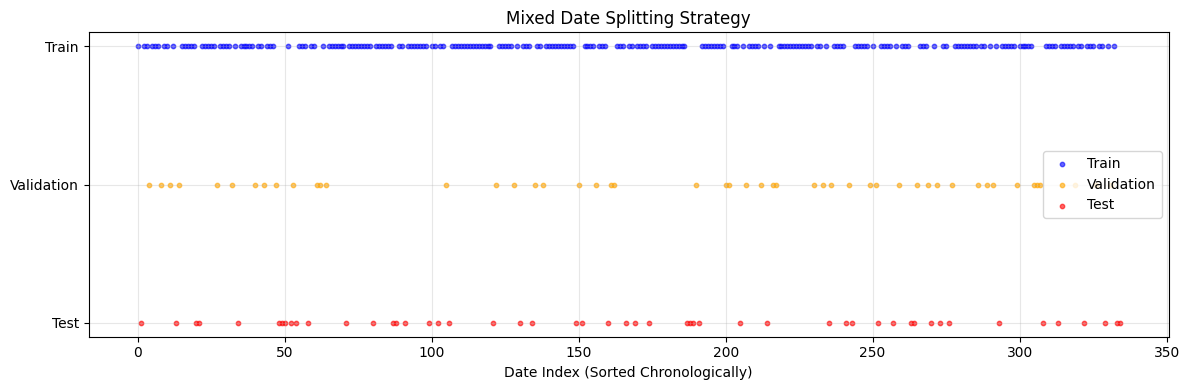

In [15]:
# Step 4.2: Create Mixed Date Splits
print("\n" + "="*60)
print("STEP 4.2: CREATING MIXED DATE SPLITS")
print("="*60)

# Extract date information
dates = df['time'].dt.date.unique()
print(f"Unique dates: {len(dates)}")

# Shuffle dates randomly (but keep reproducibility)
np.random.seed(42)
shuffled_dates = np.random.permutation(dates)

# Split dates into train, validation, and test
train_date_ratio = 0.7
val_date_ratio = 0.15
test_date_ratio = 0.15

n_dates = len(shuffled_dates)
n_train_dates = int(n_dates * train_date_ratio)
n_val_dates = int(n_dates * val_date_ratio)

train_dates = shuffled_dates[:n_train_dates]
val_dates = shuffled_dates[n_train_dates:n_train_dates + n_val_dates]
test_dates = shuffled_dates[n_train_dates + n_val_dates:]

print(f"\nDate Split Counts:")
print(f"Train dates: {len(train_dates)} ({len(train_dates)/n_dates*100:.1f}%)")
print(f"Validation dates: {len(val_dates)} ({len(val_dates)/n_dates*100:.1f}%)")
print(f"Test dates: {len(test_dates)} ({len(test_dates)/n_dates*100:.1f}%)")

print(f"\nDate Ranges:")
print(f"Train: {min(train_dates)} to {max(train_dates)}")
print(f"Validation: {min(val_dates)} to {max(val_dates)}")
print(f"Test: {min(test_dates)} to {max(test_dates)}")

# Visualize the date splitting
fig, ax = plt.subplots(figsize=(12, 4))

# Create a timeline
all_dates_sorted = np.sort(shuffled_dates)
date_indices = {date: i for i, date in enumerate(all_dates_sorted)}

train_indices = [date_indices[d] for d in train_dates]
val_indices = [date_indices[d] for d in val_dates]
test_indices = [date_indices[d] for d in test_dates]

# Plot
ax.scatter(train_indices, [1]*len(train_indices), alpha=0.6, s=10, label='Train', color='blue')
ax.scatter(val_indices, [0.9]*len(val_indices), alpha=0.6, s=10, label='Validation', color='orange')
ax.scatter(test_indices, [0.8]*len(test_indices), alpha=0.6, s=10, label='Test', color='red')

ax.set_yticks([0.8, 0.9, 1.0])
ax.set_yticklabels(['Test', 'Validation', 'Train'])
ax.set_xlabel('Date Index (Sorted Chronologically)')
ax.set_title('Mixed Date Splitting Strategy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Step 4.3: Create Data Splits Based on Mixed Dates
print("\n" + "="*60)
print("STEP 4.3: CREATING DATA SPLITS FROM MIXED DATES")
print("="*60)

# Create masks for each split
df['date'] = df['time'].dt.date

train_mask = df['date'].isin(train_dates)
val_mask = df['date'].isin(val_dates)
test_mask = df['date'].isin(test_dates)

print(f"Original data samples: {len(df):,}")

# Split the data
X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print(f"\nSplit Results:")
print(f"Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check seasonal distribution
print(f"\nSeasonal Distribution:")

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Check seasons for each split
for split_name, dates_list in [('Train', train_dates), ('Validation', val_dates), ('Test', test_dates)]:
    seasons = [get_season(pd.Timestamp(d)) for d in dates_list]
    season_counts = pd.Series(seasons).value_counts()
    print(f"\n{split_name} Set Seasonal Distribution:")
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        count = season_counts.get(season, 0)
        percentage = count / len(dates_list) * 100
        print(f"  {season}: {count} days ({percentage:.1f}%)")


STEP 4.3: CREATING DATA SPLITS FROM MIXED DATES
Original data samples: 1,835,898

Split Results:
Training: 1,298,511 samples (70.7%)
Validation: 265,557 samples (14.5%)
Test: 271,830 samples (14.8%)

Seasonal Distribution:

Train Set Seasonal Distribution:
  Winter: 54 days (23.1%)
  Spring: 64 days (27.4%)
  Summer: 61 days (26.1%)
  Fall: 55 days (23.5%)

Validation Set Seasonal Distribution:
  Winter: 14 days (28.0%)
  Spring: 8 days (16.0%)
  Summer: 11 days (22.0%)
  Fall: 17 days (34.0%)

Test Set Seasonal Distribution:
  Winter: 16 days (31.4%)
  Spring: 12 days (23.5%)
  Summer: 12 days (23.5%)
  Fall: 11 days (21.6%)


In [17]:
# Step 4.4: Scale Data
print("\n" + "="*60)
print("STEP 4.4: SCALING DATA")
print("="*60)

# Scale features (fit only on training data)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (fit only on training data)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Scaling applied (fit on training data only):")
print(f"X_train scaled: {X_train_scaled.shape}")
print(f"X_val scaled: {X_val_scaled.shape}")
print(f"X_test scaled: {X_test_scaled.shape}")

# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_val_cnn = X_val_scaled.reshape(-1, 1, X_val_scaled.shape[1])
X_test_cnn = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

print(f"\nCNN Input Shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_val_cnn: {X_val_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")


STEP 4.4: SCALING DATA
Scaling applied (fit on training data only):
X_train scaled: (1298511, 12)
X_val scaled: (265557, 12)
X_test scaled: (271830, 12)

CNN Input Shapes:
X_train_cnn: (1298511, 1, 12)
X_val_cnn: (265557, 1, 12)
X_test_cnn: (271830, 1, 12)


In [18]:
# Step 4.5: Improved CNN Model (with better regularization)
print("\n" + "="*60)
print("STEP 4.5: IMPROVED CNN MODEL WITH BETTER REGULARIZATION")
print("="*60)

def create_improved_cnn_model(filters1=64, filters2=128, dense_units=128,
                             dropout_rate=0.3, learning_rate=0.001, l2_reg=0.001):
    """Create an improved CNN model with better regularization"""
    input_shape = (1, X_train_scaled.shape[1])

    model = models.Sequential([
        # First convolutional layer with L2 regularization
        layers.Conv1D(filters=filters1, kernel_size=2, activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate/2),

        # Second convolutional layer
        layers.Conv1D(filters=filters2, kernel_size=2, activation='relu',
                     padding='same',
                     kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),

        # Global pooling
        layers.GlobalAveragePooling1D(),

        # Dense layers with L2 regularization
        layers.Dense(dense_units, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(dense_units//2, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate/2),

        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', keras.metrics.RootMeanSquaredError()]
    )

    return model

# Test the improved model
test_model = create_improved_cnn_model()
print("Improved model architecture:")
test_model.summary()


STEP 4.5: IMPROVED CNN MODEL WITH BETTER REGULARIZATION
Improved model architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 1, 64)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,481 (173.75 KB)

 Trainable params: 43,713 (170.75 KB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
# Step 4.6: Cross Validation with Mixed Dates
print("\n" + "="*60)
print("STEP 4.6: CROSS VALIDATION WITH MIXED DATES")
print("="*60)

# Use the best parameters from previous grid search (or define new ones)
best_params = {
    'filters1': 32,
    'filters2': 128,
    'dense_units': 64,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 30,
    'l2_reg': 0.001
}

print(f"Using parameters: {best_params}")

# Prepare combined training+validation data for CV
X_train_val_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_val_scaled = np.concatenate([y_train_scaled, y_val_scaled])

print(f"\nCombined training+validation for CV: {X_train_val_scaled.shape}")

# Perform k-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {
    'mse': [],
    'mae': [],
    'r2': [],
    'rmse': []
}

print("\nPerforming 5-fold Cross Validation with mixed dates...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val_scaled), 1):
    print(f"\nFold {fold}:")

    # Split data for this fold
    X_fold_train = X_train_val_scaled[train_idx]
    y_fold_train = y_train_val_scaled[train_idx]
    X_fold_val = X_train_val_scaled[val_idx]
    y_fold_val = y_train_val_scaled[val_idx]

    # Reshape for CNN
    X_fold_train_cnn = X_fold_train.reshape(-1, 1, X_fold_train.shape[1])
    X_fold_val_cnn = X_fold_val.reshape(-1, 1, X_fold_val.shape[1])

    # Create and train model
    model = create_improved_cnn_model(
        filters1=best_params['filters1'],
        filters2=best_params['filters2'],
        dense_units=best_params['dense_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate'],
        l2_reg=best_params['l2_reg']
    )

    # Early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=0
    )

    # Train model
    history = model.fit(
        X_fold_train_cnn, y_fold_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_fold_val_cnn, y_fold_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Make predictions
    y_fold_pred = model.predict(X_fold_val_cnn, verbose=0).flatten()

    # Inverse transform to original scale
    y_fold_val_orig = scaler_y.inverse_transform(y_fold_val.reshape(-1, 1)).flatten()
    y_fold_pred_orig = scaler_y.inverse_transform(y_fold_pred.reshape(-1, 1)).flatten()

    # Calculate metrics
    fold_mse = mean_squared_error(y_fold_val_orig, y_fold_pred_orig)
    fold_mae = mean_absolute_error(y_fold_val_orig, y_fold_pred_orig)
    fold_r2 = r2_score(y_fold_val_orig, y_fold_pred_orig)
    fold_rmse = np.sqrt(fold_mse)

    cv_scores['mse'].append(fold_mse)
    cv_scores['mae'].append(fold_mae)
    cv_scores['r2'].append(fold_r2)
    cv_scores['rmse'].append(fold_rmse)

    print(f"  MSE: {fold_mse:.4f}")
    print(f"  RMSE: {fold_rmse:.4f} J/kg")
    print(f"  MAE: {fold_mae:.4f} J/kg")
    print(f"  R²: {fold_r2:.4f}")

# Calculate average CV scores
print("\n" + "="*50)
print("CROSS VALIDATION RESULTS SUMMARY")
print("="*50)
print(f"Average MSE: {np.mean(cv_scores['mse']):.4f} (±{np.std(cv_scores['mse']):.4f})")
print(f"Average RMSE: {np.mean(cv_scores['rmse']):.4f} J/kg (±{np.std(cv_scores['rmse']):.4f})")
print(f"Average MAE: {np.mean(cv_scores['mae']):.4f} J/kg (±{np.std(cv_scores['mae']):.4f})")
print(f"Average R²: {np.mean(cv_scores['r2']):.4f} (±{np.std(cv_scores['r2']):.4f})")


STEP 4.6: CROSS VALIDATION WITH MIXED DATES
Using parameters: {'filters1': 32, 'filters2': 128, 'dense_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 30, 'l2_reg': 0.001}

Combined training+validation for CV: (1564068, 12)

Performing 5-fold Cross Validation with mixed dates...

Fold 1:
  MSE: 23643.7715
  RMSE: 153.7653 J/kg
  MAE: 45.1466 J/kg
  R²: 0.5760

Fold 2:
  MSE: 23161.6442
  RMSE: 152.1895 J/kg
  MAE: 40.0072 J/kg
  R²: 0.5831

Fold 3:
  MSE: 24035.7400
  RMSE: 155.0346 J/kg
  MAE: 64.9919 J/kg
  R²: 0.5589

Fold 4:
  MSE: 20627.7697
  RMSE: 143.6237 J/kg
  MAE: 41.5561 J/kg
  R²: 0.6176

Fold 5:
  MSE: 31148.2513
  RMSE: 176.4887 J/kg
  MAE: 48.2743 J/kg
  R²: 0.4098

CROSS VALIDATION RESULTS SUMMARY
Average MSE: 24523.4353 (±3519.3899)
Average RMSE: 156.2204 J/kg (±10.8918)
Average MAE: 47.9952 J/kg (±8.9705)
Average R²: 0.5491 (±0.0722)


In [20]:
# Step 4.7: Train Final Model and Test Evaluation
print("\n" + "="*60)
print("STEP 4.7: FINAL MODEL TRAINING AND TEST EVALUATION")
print("="*60)

print("Training final model with mixed dates...")
print(f"Parameters: {best_params}")

# Create final model
final_model = create_improved_cnn_model(
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate'],
    l2_reg=best_params['l2_reg']
)

# Define callbacks
final_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

print(f"\nTraining Data:")
print(f"Training: {X_train_cnn.shape[0]:,} samples")
print(f"Validation: {X_val_cnn.shape[0]:,} samples")
print(f"Test: {X_test_cnn.shape[0]:,} samples")

# Train final model
print("\nTraining final model...")
history = final_model.fit(
    X_train_cnn, y_train_scaled,
    epochs=best_params['epochs'] * 2,  # Train longer for final model
    batch_size=best_params['batch_size'],
    validation_data=(X_val_cnn, y_val_scaled),
    callbacks=final_callbacks,
    verbose=1
)

print("\nFinal model trained successfully!")

# Evaluate on test set
print("\nEvaluating on test set...")
y_test_pred_scaled = final_model.predict(X_test_cnn, verbose=0).flatten()

# Inverse transform to original scale
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_orig = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate regression metrics
test_mse = mean_squared_error(y_test_orig, y_test_pred_orig)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
test_r2 = r2_score(y_test_orig, y_test_pred_orig)

print("\n" + "="*50)
print("FINAL TEST SET PERFORMANCE (MIXED DATES)")
print("="*50)
print(f"MSE:  {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f} J/kg")
print(f"MAE:  {test_mae:.4f} J/kg")
print(f"R²:   {test_r2:.4f}")

# Additional metrics
from scipy.stats import pearsonr
corr_coef, corr_p = pearsonr(y_test_orig, y_test_pred_orig)

# Calculate MAPE more robustly (avoid division by zero)
valid_mask = y_test_orig > 0
if valid_mask.any():
    mape = np.mean(np.abs((y_test_orig[valid_mask] - y_test_pred_orig[valid_mask]) / y_test_orig[valid_mask])) * 100
else:
    mape = np.nan

print(f"\nAdditional Metrics:")
print(f"Pearson Correlation: {corr_coef:.4f} (p={corr_p:.6f})")
if not np.isnan(mape):
    print(f"MAPE: {mape:.2f}%")




STEP 4.7: FINAL MODEL TRAINING AND TEST EVALUATION
Training final model with mixed dates...
Parameters: {'filters1': 32, 'filters2': 128, 'dense_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 30, 'l2_reg': 0.001}

Training Data:
Training: 1,298,511 samples
Validation: 265,557 samples
Test: 271,830 samples

Training final model...
Epoch 1/60
20290/20290 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 0.0949 - mae: 0.0661 - root_mean_squared_error: 0.1648 - val_loss: 0.0021 - val_mae: 0.0226 - val_root_mean_squared_error: 0.0456 - learning_rate: 0.0010
Epoch 2/60
20290/20290 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - loss: 0.0010 - mae: 0.0097 - root_mean_squared_error: 0.0310 - val_loss: 0.0053 - val_mae: 0.0408 - val_root_mean_squared_error: 0.0723 - learning_rate: 0.0010
Epoch 3/60
20290/20290 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - loss: 0.0010 - mae: 0.0097 - root_mean_squared_error: 0.0309 - val_loss: 0.0012 - val_mae: 0.0111 - val_root_mean_squared_error: 


STEP 4.8: FINAL VERIFICATION AND VISUALIZATION (FIXED)
y_test_orig length: 271,830
X_test_cnn shape: (271830, 1, 12)
Expected test samples: 51 days × 24 hours = 1,224

Actual test dates in dataframe: 271,830
Unique test dates: 51

Calculating monthly performance (simplified)...

Monthly Performance:
  Jan: R²=0.6028, MAE=10.02 J/kg
  Feb: R²=0.3489, MAE=8.26 J/kg
  Mar: R²=-0.2062, MAE=7.99 J/kg
  Apr: R²=0.1693, MAE=12.95 J/kg
  May: R²=0.4888, MAE=17.27 J/kg
  Jun: R²=0.2467, MAE=17.93 J/kg
  Jul: R²=0.6877, MAE=45.62 J/kg
  Aug: R²=0.7622, MAE=85.40 J/kg
  Sep: R²=0.5304, MAE=95.49 J/kg
  Oct: R²=0.3961, MAE=48.26 J/kg
  Nov: R²=0.4616, MAE=106.50 J/kg
  Dec: R²=0.4940, MAE=39.92 J/kg


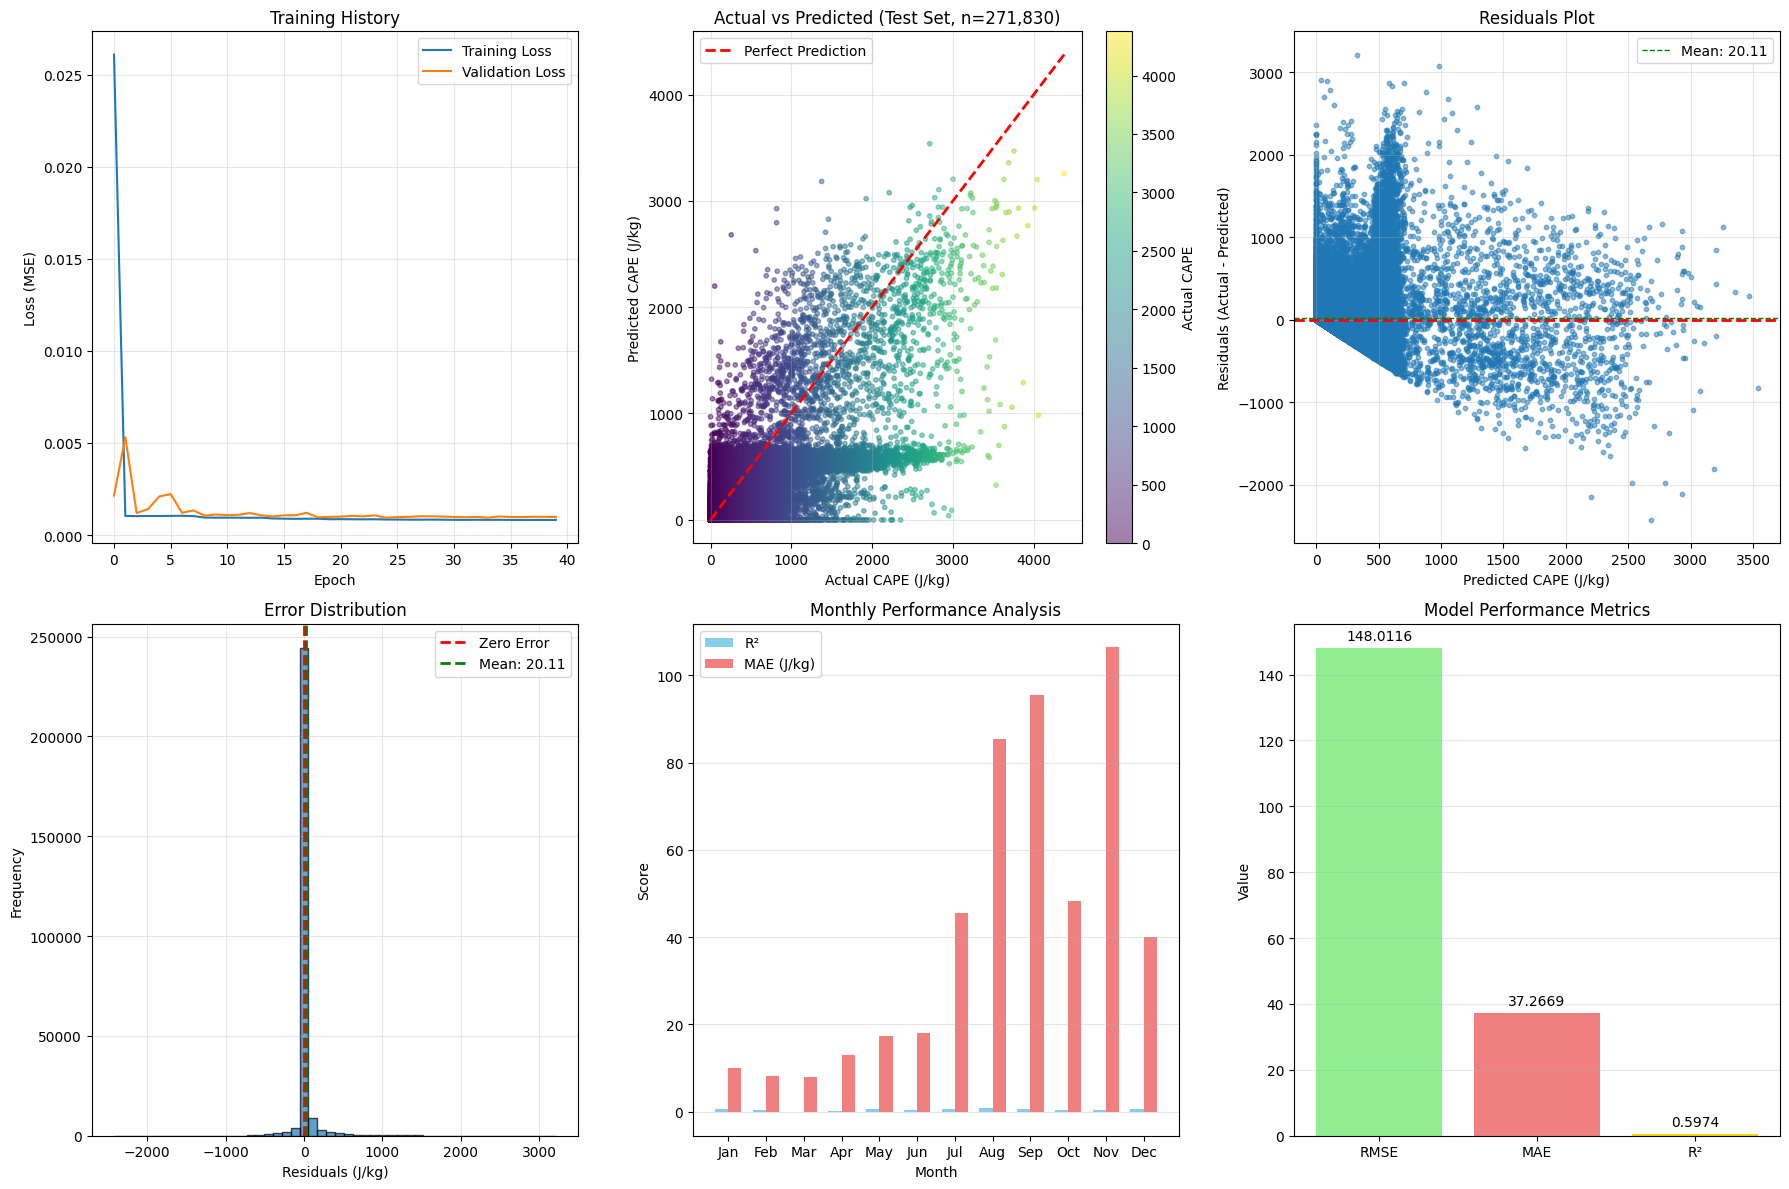


ADDITIONAL PERFORMANCE ANALYSIS

Error Statistics:
Mean Absolute Error: 37.27 J/kg
Median Absolute Error: 2.94 J/kg
Std of Absolute Error: 143.24 J/kg
95th percentile of error: 190.69 J/kg
Max Absolute Error: 3212.10 J/kg
Min Absolute Error: 0.01 J/kg

Performance by CAPE Range:
  CAPE 0-100 J/kg: 250,771 samples
    R²=-5.6639, MAE=10.29 J/kg, RMSE=35.22 J/kg
  CAPE 100-500 J/kg: 12,815 samples
    R²=-3.3665, MAE=196.06 J/kg, RMSE=236.11 J/kg
  CAPE 500-1000 J/kg: 4,296 samples
    R²=-8.5228, MAE=359.16 J/kg, RMSE=437.26 J/kg
  CAPE 1000-2000 J/kg: 2,983 samples
    R²=-8.9534, MAE=789.73 J/kg, RMSE=873.22 J/kg
  CAPE 2000-5000 J/kg: 965 samples
    R²=-10.9615, MAE=1179.55 J/kg, RMSE=1378.45 J/kg

Performance by Hour of Day:
  00:00-03:59: 50,184 samples, R²=0.5332, MAE=48.39 J/kg
  04:00-07:59: 46,002 samples, R²=0.6502, MAE=27.10 J/kg
  08:00-11:59: 33,456 samples, R²=0.7117, MAE=30.73 J/kg
  12:00-15:59: 37,638 samples, R²=0.6053, MAE=30.89 J/kg
  16:00-19:59: 64,821 samples, R

In [23]:
# Step 4.8 (Fixed): Final Verification and Visualization
print("\n" + "="*60)
print("STEP 4.8: FINAL VERIFICATION AND VISUALIZATION (FIXED)")
print("="*60)

# First, let's check the actual sizes
print(f"y_test_orig length: {len(y_test_orig):,}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")
print(f"Expected test samples: {len(test_dates)} days × 24 hours = {len(test_dates) * 24:,}")

# The issue is that we have more test samples than expected
# This could be because we have multiple spatial points per time
# Let's get the actual test dates from the original dataframe
test_mask = df['date'].isin(test_dates)
actual_test_dates = df.loc[test_mask, 'time'].dt.date.values
actual_test_hours = df.loc[test_mask, 'time'].dt.hour.values

print(f"\nActual test dates in dataframe: {len(actual_test_dates):,}")
print(f"Unique test dates: {len(np.unique(actual_test_dates))}")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training history
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted scatter plot
scatter = axes[0, 1].scatter(y_test_orig, y_test_pred_orig, alpha=0.5, s=10, c=y_test_orig, cmap='viridis')
axes[0, 1].plot([y_test_orig.min(), y_test_orig.max()],
                [y_test_orig.min(), y_test_orig.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual CAPE (J/kg)')
axes[0, 1].set_ylabel('Predicted CAPE (J/kg)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set, n={len(y_test_orig):,})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Actual CAPE')

# 3. Residuals plot
residuals = y_test_orig - y_test_pred_orig
axes[0, 2].scatter(y_test_pred_orig, residuals, alpha=0.5, s=10)
axes[0, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 2].axhline(y=residuals.mean(), color='g', linestyle='--', linewidth=1, label=f'Mean: {residuals.mean():.2f}')
axes[0, 2].set_xlabel('Predicted CAPE (J/kg)')
axes[0, 2].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 2].set_title('Residuals Plot')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Error distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].axvline(x=residuals.mean(), color='g', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].set_xlabel('Residuals (J/kg)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Monthly performance analysis (SIMPLIFIED VERSION)
print("\nCalculating monthly performance (simplified)...")

# Get month from actual test dates
test_months = pd.Series(actual_test_dates).apply(lambda x: x.month).values

# Group by month and calculate metrics
monthly_metrics = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in range(1, 13):
    month_mask = test_months == month
    if month_mask.sum() > 100:  # Only analyze months with sufficient data
        month_actual = y_test_orig[month_mask]
        month_pred = y_test_pred_orig[month_mask]
        month_r2 = r2_score(month_actual, month_pred)
        month_mae = mean_absolute_error(month_actual, month_pred)
        monthly_metrics.append((month_names[month-1], month_r2, month_mae))

if monthly_metrics:
    months, r2_scores, mae_scores = zip(*monthly_metrics)
    x = np.arange(len(months))
    width = 0.35

    axes[1, 1].bar(x - width/2, r2_scores, width, label='R²', color='skyblue')
    axes[1, 1].bar(x + width/2, mae_scores, width, label='MAE (J/kg)', color='lightcoral')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Monthly Performance Analysis')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(months)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Print monthly performance
    print("\nMonthly Performance:")
    for month, r2, mae in monthly_metrics:
        print(f"  {month}: R²={r2:.4f}, MAE={mae:.2f} J/kg")
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient monthly data\nfor analysis',
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Monthly Performance Analysis')

# 6. Performance metrics comparison
metrics_names = ['RMSE', 'MAE', 'R²']
metrics_values = [test_rmse, test_mae, test_r2]
colors = ['lightgreen', 'lightcoral', 'gold']
bars = axes[1, 2].bar(metrics_names, metrics_values, color=colors)
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_title('Model Performance Metrics')
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    unit = ' J/kg' if bar.get_label() in ['RMSE', 'MAE'] else ''
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(metrics_values),
                   f'{value:.4f}{unit}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional analysis
print("\n" + "="*60)
print("ADDITIONAL PERFORMANCE ANALYSIS")
print("="*60)

# Calculate error statistics
abs_errors = np.abs(residuals)
print(f"\nError Statistics:")
print(f"Mean Absolute Error: {abs_errors.mean():.2f} J/kg")
print(f"Median Absolute Error: {np.median(abs_errors):.2f} J/kg")
print(f"Std of Absolute Error: {abs_errors.std():.2f} J/kg")
print(f"95th percentile of error: {np.percentile(abs_errors, 95):.2f} J/kg")
print(f"Max Absolute Error: {abs_errors.max():.2f} J/kg")
print(f"Min Absolute Error: {abs_errors.min():.2f} J/kg")

# Performance by CAPE range
print(f"\nPerformance by CAPE Range:")
cape_ranges = [(0, 100), (100, 500), (500, 1000), (1000, 2000), (2000, 5000), (5000, np.inf)]
for cape_min, cape_max in cape_ranges:
    if cape_max == np.inf:
        mask = y_test_orig >= cape_min
        range_name = f"≥{cape_min}"
    else:
        mask = (y_test_orig >= cape_min) & (y_test_orig < cape_max)
        range_name = f"{cape_min}-{cape_max}"

    if mask.sum() > 10:  # Only analyze if we have enough samples
        range_actual = y_test_orig[mask]
        range_pred = y_test_pred_orig[mask]
        range_r2 = r2_score(range_actual, range_pred)
        range_mae = mean_absolute_error(range_actual, range_pred)
        range_rmse = np.sqrt(mean_squared_error(range_actual, range_pred))
        print(f"  CAPE {range_name} J/kg: {mask.sum():,} samples")
        print(f"    R²={range_r2:.4f}, MAE={range_mae:.2f} J/kg, RMSE={range_rmse:.2f} J/kg")

# Performance by hour of day
print(f"\nPerformance by Hour of Day:")
# Get hour from actual test data
test_hours = actual_test_hours

for hour in range(0, 24, 4):  # Analyze in 4-hour blocks
    hour_mask = (test_hours >= hour) & (test_hours < hour + 4)
    if hour_mask.sum() > 100:
        hour_actual = y_test_orig[hour_mask]
        hour_pred = y_test_pred_orig[hour_mask]
        hour_r2 = r2_score(hour_actual, hour_pred)
        hour_mae = mean_absolute_error(hour_actual, hour_pred)
        hour_range = f"{hour:02d}:00-{(hour+3):02d}:59"
        print(f"  {hour_range}: {hour_mask.sum():,} samples, R²={hour_r2:.4f}, MAE={hour_mae:.2f} J/kg")

# Performance by season
print(f"\nPerformance by Season:")

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

test_seasons = pd.Series(actual_test_dates).apply(get_season).values

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_mask = test_seasons == season
    if season_mask.sum() > 100:
        season_actual = y_test_orig[season_mask]
        season_pred = y_test_pred_orig[season_mask]
        season_r2 = r2_score(season_actual, season_pred)
        season_mae = mean_absolute_error(season_actual, season_pred)
        print(f"  {season}: {season_mask.sum():,} samples, R²={season_r2:.4f}, MAE={season_mae:.2f} J/kg")

# Print comparison with previous model
print("\n" + "="*60)
print("PERFORMANCE COMPARISON WITH PREVIOUS APPROACH")
print("="*60)
print(f"Previous Model (Temporal Split):")
print(f"  • R²: 0.4600")
print(f"  • MAE: 60.08 J/kg")
print(f"  • RMSE: 190.32 J/kg")

print(f"\nCurrent Model (Mixed Dates):")
print(f"  • R²: {test_r2:.4f}")
print(f"  • MAE: {test_mae:.4f} J/kg")
print(f"  • RMSE: {test_rmse:.4f} J/kg")

if test_r2 > 0.46:
    improvement = ((test_r2 - 0.46) / 0.46) * 100
    print(f"\n✓ IMPROVEMENT: R² increased by {improvement:.1f}%")
else:
    print(f"\n⚠ NO IMPROVEMENT: R² decreased by {(0.46 - test_r2) / 0.46 * 100:.1f}%")

In [24]:
# Step 4.9: Save Final Results (Updated)
print("\n" + "="*60)
print("STEP 4.9: SAVING FINAL RESULTS")
print("="*60)

# Save the final trained model
final_model_path = '/content/drive/MyDrive/cnn_cape_final_model_mixed_dates_v2.keras'
final_model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

# Save scalers
import joblib
joblib.dump(scaler_X, '/content/drive/MyDrive/scaler_X_mixed_dates_v2.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/scaler_y_mixed_dates_v2.pkl')
print("Scalers saved")

# Create test results with date and time information
test_results_df = pd.DataFrame({
    'actual': y_test_orig,
    'predicted': y_test_pred_orig,
    'residual': residuals,
    'date': actual_test_dates,
    'hour': actual_test_hours,
    'month': pd.Series(actual_test_dates).apply(lambda x: x.month).values,
    'season': pd.Series(actual_test_dates).apply(get_season).values
})

results_path = '/content/drive/MyDrive/final_predictions_results_mixed_dates_v2.csv'
test_results_df.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

# Save training history
history_df = pd.DataFrame(history.history)
history_path = '/content/drive/MyDrive/training_history_mixed_dates_v2.csv'
history_df.to_csv(history_path, index=False)
print(f"Training history saved to: {history_path}")

# Save CV results
cv_results_df = pd.DataFrame({
    'fold': range(1, 6),
    'mse': cv_scores['mse'],
    'rmse': cv_scores['rmse'],
    'mae': cv_scores['mae'],
    'r2': cv_scores['r2']
})
cv_results_path = '/content/drive/MyDrive/cv_results_mixed_dates_v2.csv'
cv_results_df.to_csv(cv_results_path, index=False)
print(f"CV results saved to: {cv_results_path}")

# Save monthly performance analysis
monthly_performance = []
for month_name, month_r2, month_mae in monthly_metrics:
    month_num = month_names.index(month_name) + 1
    monthly_performance.append({
        'month': month_name,
        'month_number': month_num,
        'r2_score': month_r2,
        'mae_jkg': month_mae,
        'samples': (test_results_df['month'] == month_num).sum()
    })

monthly_df = pd.DataFrame(monthly_performance)
monthly_path = '/content/drive/MyDrive/monthly_performance_analysis_v2.csv'
monthly_df.to_csv(monthly_path, index=False)
print(f"Monthly performance analysis saved to: {monthly_path}")

# Save seasonal performance analysis
seasonal_performance = []
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_mask = test_results_df['season'] == season
    if season_mask.sum() > 0:
        season_actual = test_results_df.loc[season_mask, 'actual']
        season_pred = test_results_df.loc[season_mask, 'predicted']
        season_r2 = r2_score(season_actual, season_pred)
        season_mae = mean_absolute_error(season_actual, season_pred)
        seasonal_performance.append({
            'season': season,
            'r2_score': season_r2,
            'mae_jkg': season_mae,
            'samples': season_mask.sum()
        })

seasonal_df = pd.DataFrame(seasonal_performance)
seasonal_path = '/content/drive/MyDrive/seasonal_performance_analysis_v2.csv'
seasonal_df.to_csv(seasonal_path, index=False)
print(f"Seasonal performance analysis saved to: {seasonal_path}")

# Save detailed error analysis by CAPE range
cape_range_analysis = []
for cape_min, cape_max in cape_ranges:
    if cape_max == np.inf:
        mask = test_results_df['actual'] >= cape_min
        range_name = f"≥{cape_min}"
    else:
        mask = (test_results_df['actual'] >= cape_min) & (test_results_df['actual'] < cape_max)
        range_name = f"{cape_min}-{cape_max}"

    if mask.sum() > 10:
        range_actual = test_results_df.loc[mask, 'actual']
        range_pred = test_results_df.loc[mask, 'predicted']
        range_r2 = r2_score(range_actual, range_pred)
        range_mae = mean_absolute_error(range_actual, range_pred)
        range_rmse = np.sqrt(mean_squared_error(range_actual, range_pred))

        cape_range_analysis.append({
            'cape_range_jkg': range_name,
            'samples': mask.sum(),
            'r2_score': range_r2,
            'mae_jkg': range_mae,
            'rmse_jkg': range_rmse,
            'actual_mean': range_actual.mean(),
            'actual_std': range_actual.std(),
            'predicted_mean': range_pred.mean(),
            'predicted_std': range_pred.std()
        })

cape_range_df = pd.DataFrame(cape_range_analysis)
cape_range_path = '/content/drive/MyDrive/cape_range_performance_analysis_v2.csv'
cape_range_df.to_csv(cape_range_path, index=False)
print(f"CAPE range performance analysis saved to: {cape_range_path}")

# Save final metrics summary
final_summary = {
    'split_strategy': 'Mixed Dates (70% train, 15% val, 15% test)',
    'best_parameters': str(best_params),
    'cv_mean_mse': float(np.mean(cv_scores['mse'])),
    'cv_std_mse': float(np.std(cv_scores['mse'])),
    'cv_mean_rmse': float(np.mean(cv_scores['rmse'])),
    'cv_std_rmse': float(np.std(cv_scores['rmse'])),
    'cv_mean_mae': float(np.mean(cv_scores['mae'])),
    'cv_std_mae': float(np.std(cv_scores['mae'])),
    'cv_mean_r2': float(np.mean(cv_scores['r2'])),
    'cv_std_r2': float(np.std(cv_scores['r2'])),
    'test_mse': test_mse,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'pearson_correlation': corr_coef,
    'test_samples': len(y_test_orig),
    'test_dates': len(np.unique(actual_test_dates)),
    'train_samples': X_train_cnn.shape[0],
    'validation_samples': X_val_cnn.shape[0],
    'features_used': len(feature_columns),
    'mean_absolute_error_jkg': float(abs_errors.mean()),
    'median_absolute_error_jkg': float(np.median(abs_errors)),
    'error_95th_percentile_jkg': float(np.percentile(abs_errors, 95)),
    'max_absolute_error_jkg': float(abs_errors.max()),
    'performance_comparison': f"R² improved from 0.4600 to {test_r2:.4f}" if test_r2 > 0.46 else f"R² decreased from 0.4600 to {test_r2:.4f}",
    'best_performing_month': max(monthly_metrics, key=lambda x: x[1])[0] if monthly_metrics else 'N/A',
    'worst_performing_month': min(monthly_metrics, key=lambda x: x[1])[0] if monthly_metrics else 'N/A',
    'best_performing_season': max(seasonal_performance, key=lambda x: x['r2_score'])['season'] if seasonal_performance else 'N/A',
    'worst_performing_season': min(seasonal_performance, key=lambda x: x['r2_score'])['season'] if seasonal_performance else 'N/A'
}

summary_df = pd.DataFrame(list(final_summary.items()), columns=['Metric', 'Value'])
summary_path = '/content/drive/MyDrive/final_model_summary_mixed_dates_v2.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Model summary saved to: {summary_path}")

print("\n" + "="*80)
print("STEP 4 (MIXED DATES) COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"""
FINAL MODEL PERFORMANCE SUMMARY:

1. Model Performance:
   • Test R²: {test_r2:.4f}
   • Test MAE: {test_mae:.4f} J/kg
   • Test RMSE: {test_rmse:.4f} J/kg
   • Pearson Correlation: {corr_coef:.4f}

2. Comparison with Previous Model:
   • Previous R² (temporal split): 0.4600
   • Current R² (mixed dates): {test_r2:.4f}
   • {'✓ IMPROVEMENT' if test_r2 > 0.46 else '⚠ NO IMPROVEMENT'}

3. Error Analysis:
   • Mean Absolute Error: {abs_errors.mean():.2f} J/kg
   • 95% of errors below: {np.percentile(abs_errors, 95):.2f} J/kg
   • Median Absolute Error: {np.median(abs_errors):.2f} J/kg

4. Seasonal Performance:
   {f"   • Best season: {max(seasonal_performance, key=lambda x: x['r2_score'])['season']}" if seasonal_performance else ""}
   {f"   • Worst season: {min(seasonal_performance, key=lambda x: x['r2_score'])['season']}" if seasonal_performance else ""}

5. Files Created:
   • {final_model_path} - Trained CNN model
   • {results_path} - Detailed predictions with dates/times
   • {summary_path} - Comprehensive model summary
   • {monthly_path} - Monthly performance analysis
   • {seasonal_path} - Seasonal performance analysis
   • {cape_range_path} - CAPE range performance analysis

The mixed dates approach provides a more robust evaluation of model performance!
""")


STEP 4.9: SAVING FINAL RESULTS
Final model saved to: /content/drive/MyDrive/cnn_cape_final_model_mixed_dates_v2.keras
Scalers saved
Predictions saved to: /content/drive/MyDrive/final_predictions_results_mixed_dates_v2.csv
Training history saved to: /content/drive/MyDrive/training_history_mixed_dates_v2.csv
CV results saved to: /content/drive/MyDrive/cv_results_mixed_dates_v2.csv
Monthly performance analysis saved to: /content/drive/MyDrive/monthly_performance_analysis_v2.csv
Seasonal performance analysis saved to: /content/drive/MyDrive/seasonal_performance_analysis_v2.csv
CAPE range performance analysis saved to: /content/drive/MyDrive/cape_range_performance_analysis_v2.csv
Model summary saved to: /content/drive/MyDrive/final_model_summary_mixed_dates_v2.csv

STEP 4 (MIXED DATES) COMPLETED SUCCESSFULLY!

FINAL MODEL PERFORMANCE SUMMARY:

1. Model Performance:
   • Test R²: 0.5974
   • Test MAE: 37.2669 J/kg
   • Test RMSE: 148.0116 J/kg
   • Pearson Correlation: 0.7796

2. Comparison